In [ ]:
!pip install bert_score
!pip install rouge_score

In [ ]:
!pip install evaluate
!pip install sentence-transformers
#This library uses HuggingFace’s transformers

In [ ]:
import json
import numpy as np
import pandas as pd
import requests
# metrics
from sentence_transformers import SentenceTransformer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics.pairwise import cosine_similarity
from evaluate import load
from statistics import mean
# graphs
import matplotlib.pyplot as plt
import seaborn as sns
# gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
bertscore = load("bertscore")
rouge = load('rouge')

# **RETRIEVAL OF DATA**

In [ ]:
dataset_file = open("/content/gdrive/MyDrive/Jacopo/test_con_parafrasi.json")
test_set_con_parafrasi = json.load(dataset_file)
dataset_file.close()

In [ ]:
jj = []
tomm = []
lucia = []
original = []
for index in range(50):
  original.append(test_set_con_parafrasi[index]["statement"])
  jj.append(test_set_con_parafrasi[index]["parafrasi_jj"])
  tomm.append(test_set_con_parafrasi[index]["parafrasi_tommaso"])
  lucia.append(test_set_con_parafrasi[index]["parafrasi_lucia"])

# **BLOCCO 1**
annotatore umano verso l'originale

# cosine similarity

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
jj_embeddings = model.encode(jj)
tomm_embeddings = model.encode(tomm)
lucia_embeddings = model.encode(lucia)
original_embeddings = model.encode(original)

In [ ]:
blocco1 = []
for index in range(50):
  blocco1.append(
      cosine_similarity(
        [original_embeddings[index]],
        [jj_embeddings[index], tomm_embeddings[index], lucia_embeddings[index]]
      )
  )

Text(0, 0.5, 'cosine similarity')

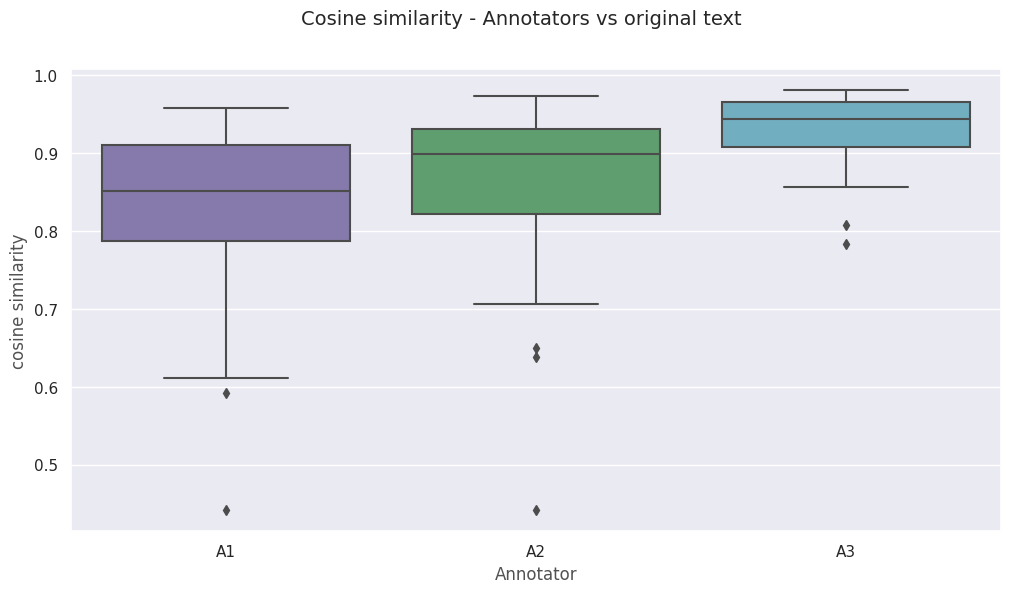

In [ ]:
blocco1_cosine_table = {
        'A1': [cosine[0][0] for cosine in blocco1],
        "A2" : [cosine[0][1] for cosine in blocco1],
        "A3" : [cosine[0][2] for cosine in blocco1]
        }

blocco1_cosine_df = pd.DataFrame(blocco1_cosine_table)

# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('Cosine similarity - Annotators vs original text', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco1_cosine_df, palette=["m", "g", "c"])
ax.set_xlabel("Annotator",size = 12,alpha=0.8)
ax.set_ylabel("cosine similarity",size = 12,alpha=0.8)

In [ ]:
blocco1_cosine_df
blocco1_cosine_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/1cosine.xlsx")
#rows = first 50 statements of the test_set

# bleu

In [ ]:
def bleu(original_text, parafrasi):
  reference = [ original_text.split() ]
  candidate = parafrasi.split()
  return sentence_bleu(reference, candidate, smoothing_function = SmoothingFunction().method1)

blocco1_bleu = []
for index in range(50):
  blocco1_bleu.append(
      [
          bleu(original[index], jj[index]),
          bleu(original[index], tomm[index]),
          bleu(original[index], lucia[index])
       ]
      )

Text(0, 0.5, 'bleu score')

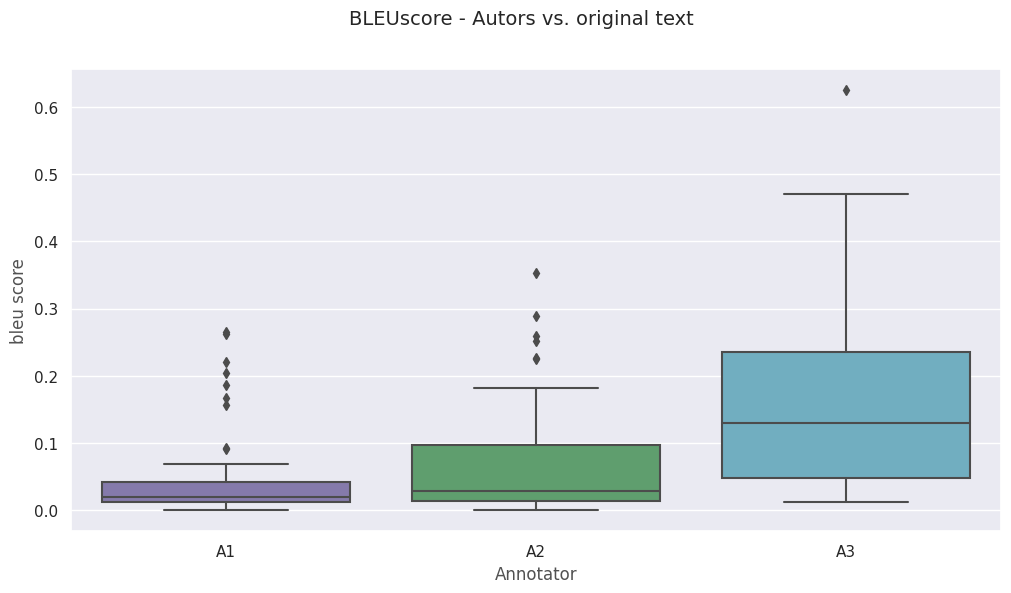

In [ ]:
blocco1_bleu_table = {
        'A1': [bleu[0] for bleu in blocco1_bleu],
        "A2" : [bleu[1] for bleu in blocco1_bleu],
        "A3" : [bleu[2] for bleu in blocco1_bleu]
        }

blocco1_bleu_df = pd.DataFrame(blocco1_bleu_table)

# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('BLEUscore - Autors vs. original text', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco1_bleu_df, palette=["m", "g", "c"])
ax.set_xlabel("Annotator",size = 12,alpha=0.8)
ax.set_ylabel("bleu score",size = 12,alpha=0.8)

In [ ]:
blocco1_bleu_df
blocco1_bleu_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/1bleu.xlsx")

# BERT

In [ ]:
blocco1_jj_bert = []
blocco1_tomm_bert = []
blocco1_lucia_bert = []
for i in range(50):
  blocco1_jj_bert.append(bertscore.compute(predictions = [jj[i]], references = [original[i]], lang="it"))
  blocco1_tomm_bert.append(bertscore.compute(predictions = [tomm[i]], references = [original[i]], lang="it"))
  blocco1_lucia_bert.append(bertscore.compute(predictions = [lucia[i]], references = [original[i]], lang="it"))

In [ ]:
for i in range(50):
  del blocco1_jj_bert[i]['hashcode']
  del blocco1_tomm_bert[i]['hashcode']
  del blocco1_lucia_bert[i]['hashcode']

In [ ]:
blocco1_bert_table = []
for i in range(50):
  for key in blocco1_jj_bert[i]:
    blocco1_bert_table.append({"scoreType" : key,
                    "scoreValue" : blocco1_jj_bert[i][key][0],
                    "annotator" : "A1"
                    })
  for key in blocco1_tomm_bert[i]:
    blocco1_bert_table.append({"scoreType" : key,
                    "scoreValue" : blocco1_tomm_bert[i][key][0],
                    "annotator" : "A2"
                    })
  for key in blocco1_lucia_bert[i]:
    blocco1_bert_table.append({"scoreType" : key,
                    "scoreValue" : blocco1_lucia_bert[i][key][0],
                    "annotator" : "A3"
                    })

Text(0, 0.5, 'BERTscore')

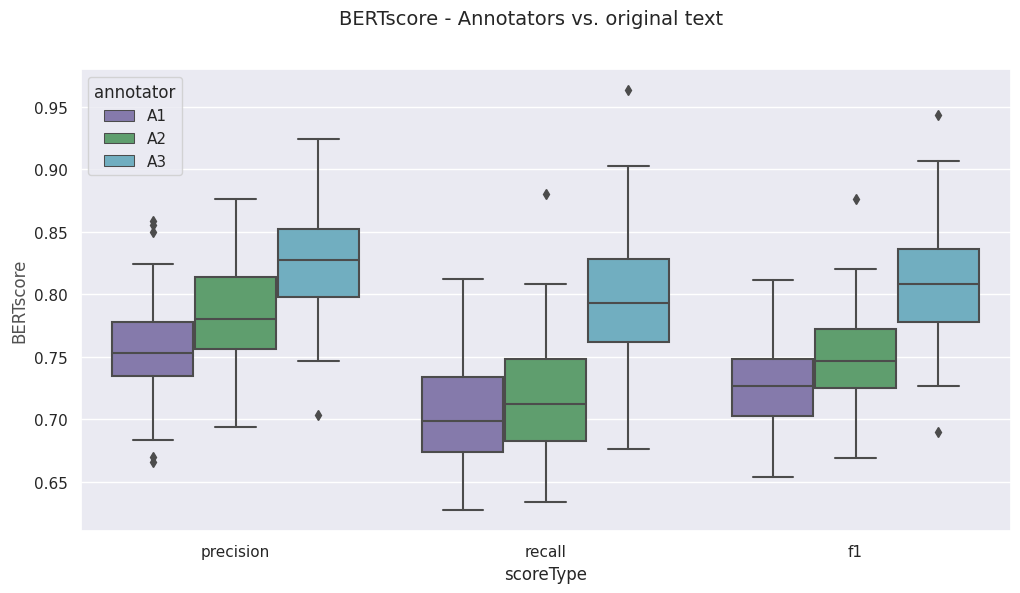

In [ ]:
blocco1_bert_df = pd.DataFrame(blocco1_bert_table)
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('BERTscore - Annotators vs. original text', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco1_bert_df, x = "scoreType", y = "scoreValue", hue="annotator", palette=["m", "g", "c"])
ax.set_ylabel("BERTscore",size = 12,alpha=0.8)

In [ ]:
blocco1_bert_better_table = {
    "A1-precision" : [row["precision"][0] for row in blocco1_jj_bert],
    "A1-recall" : [row["recall"][0] for row in blocco1_jj_bert],
    "A1-f1" : [row["f1"][0] for row in blocco1_jj_bert],
    "A2-precision" : [row["precision"][0] for row in blocco1_tomm_bert],
    "A2-recall" : [row["recall"][0] for row in blocco1_tomm_bert],
    "A2-f1" : [row["f1"][0] for row in blocco1_tomm_bert],
    "A3-precision" : [row["precision"][0] for row in blocco1_lucia_bert],
    "A3-recall" : [row["recall"][0] for row in blocco1_lucia_bert],
    "A3-f1" : [row["f1"][0] for row in blocco1_lucia_bert],
}

In [ ]:
blocco1_bert_better_df = pd.DataFrame(blocco1_bert_better_table)
blocco1_bert_better_df

blocco1_bert_better_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/1bert.xlsx")

# ROUGE

In [ ]:
blocco1_jj_rouge = []
blocco1_tomm_rouge = []
blocco1_lucia_rouge = []
for i in range(50):
  blocco1_jj_rouge.append(rouge.compute(predictions = [jj[i]], references = [original[i]]))
  blocco1_tomm_rouge.append(rouge.compute(predictions = [tomm[i]], references = [original[i]]))
  blocco1_lucia_rouge.append(rouge.compute(predictions = [lucia[i]], references = [original[i]]))

In [ ]:
blocco1_rouge_table = []
for i in range(50):
  for key in blocco1_jj_rouge[i]:
    blocco1_rouge_table.append({"scoreType" : key,
                    "scoreValue" : blocco1_jj_rouge[i][key],
                    "annotator" : "A1"
                    })
  for key in blocco1_tomm_rouge[i]:
    blocco1_rouge_table.append({"scoreType" : key,
                    "scoreValue" : blocco1_tomm_rouge[i][key],
                    "annotator" : "A2"
                    })
  for key in blocco1_lucia_rouge[i]:
    blocco1_rouge_table.append({"scoreType" : key,
                    "scoreValue" : blocco1_lucia_rouge[i][key],
                    "annotator" : "A3"
                    })

Text(0, 0.5, 'ROUGEscore')

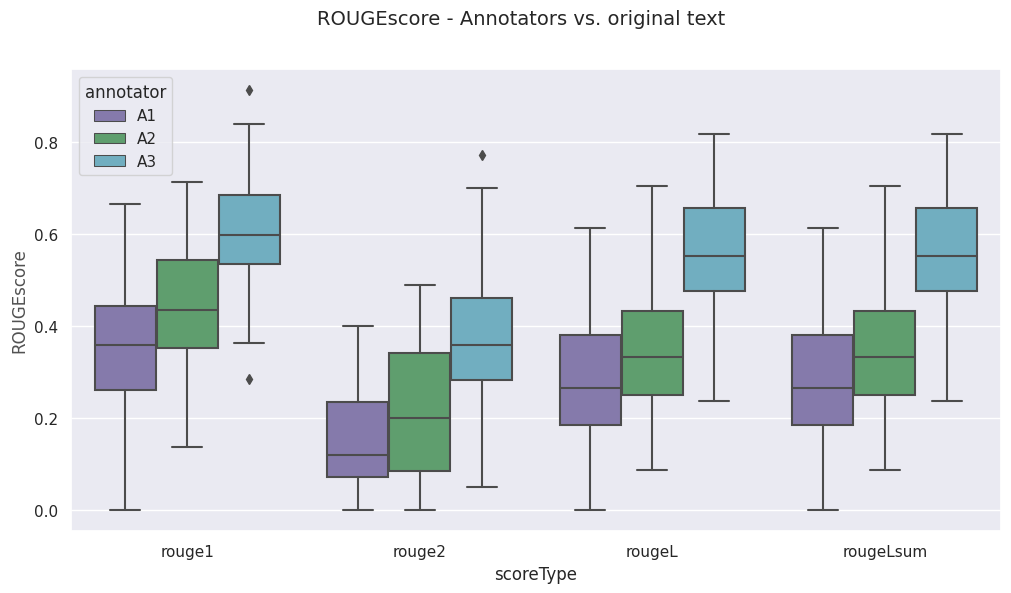

In [ ]:
blocco1_rouge_df = pd.DataFrame(blocco1_rouge_table)
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('ROUGEscore - Annotators vs. original text', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco1_rouge_df, x = "scoreType", y = "scoreValue", hue="annotator", palette=["m", "g", "c"])
ax.set_ylabel("ROUGEscore",size = 12,alpha=0.8)

In [ ]:
blocco1_rouge_better_table = {
    "A1-rouge1" : [row["rouge1"] for row in blocco1_jj_rouge],
    "A1-rouge2" : [row["rouge2"] for row in blocco1_jj_rouge],
    "A1-rougeL" : [row["rougeL"] for row in blocco1_jj_rouge],
    "A1-rougeLsum" : [row["rougeLsum"] for row in blocco1_jj_rouge],
    "A2-rouge1" : [row["rouge1"] for row in blocco1_tomm_rouge],
    "A2-rouge2" : [row["rouge2"] for row in blocco1_tomm_rouge],
    "A2-rougeL" : [row["rougeL"] for row in blocco1_tomm_rouge],
    "A2-rougeLsum" : [row["rougeLsum"] for row in blocco1_tomm_rouge],
    "A3-rouge1" : [row["rouge1"] for row in blocco1_lucia_rouge],
    "A3-rouge2" : [row["rouge2"] for row in blocco1_lucia_rouge],
    "A3-rougeL" : [row["rougeL"] for row in blocco1_lucia_rouge],
    "A3-rougeLsum" : [row["rougeLsum"] for row in blocco1_lucia_rouge],
}

In [ ]:
blocco1_rouge_better_df = pd.DataFrame(blocco1_rouge_better_table)
blocco1_rouge_better_df

blocco1_rouge_better_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/1rouge.xlsx")

# **BLOCCO 2**
annotatore umano verso annotatore umano

# cosine similarity

In [ ]:
jj_to_tomm = []
jj_to_lucia = []
lucia_to_tomm = []

def umani_contro_umani(jj_parafrasi, tomm_parafrasi, lucia_parafrasi):
  jj_to_tomm.append(cosine_similarity([jj_parafrasi], [tomm_parafrasi])[0][0])
  jj_to_lucia.append(cosine_similarity([jj_parafrasi], [lucia_parafrasi])[0][0])
  lucia_to_tomm.append(cosine_similarity([lucia_parafrasi], [tomm_parafrasi])[0][0])

for index in range(50):
  umani_contro_umani(jj_embeddings[index], tomm_embeddings[index], lucia_embeddings[index])

Text(0, 0.5, 'Cosine similarity')

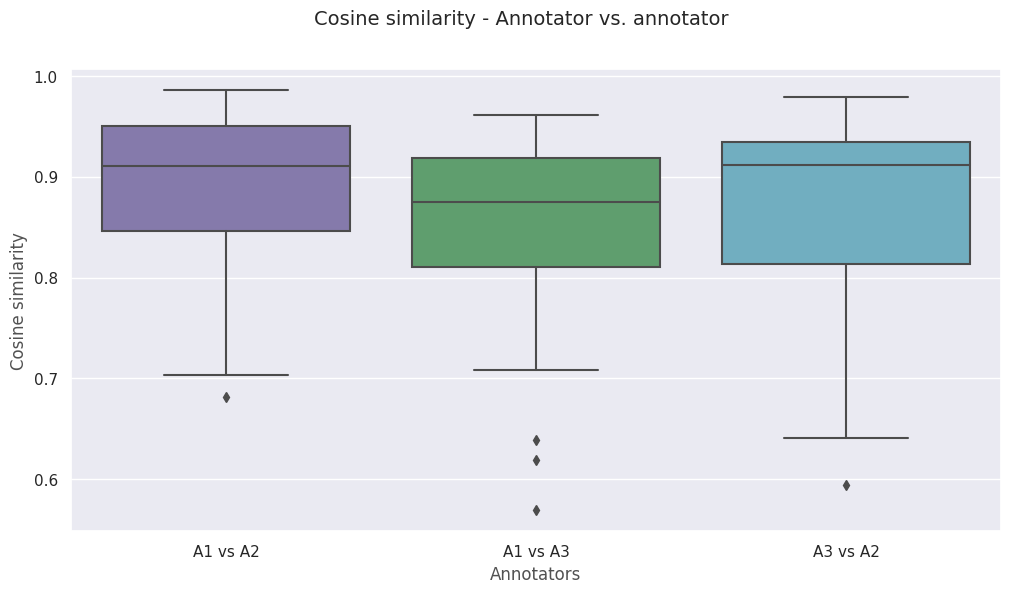

In [ ]:
blocco2_cosine_table = {
        'A1 vs A2': jj_to_tomm ,
        "A1 vs A3" : jj_to_lucia,
        "A3 vs A2" : lucia_to_tomm
        }

blocco2_cosine_df = pd.DataFrame(blocco2_cosine_table)

# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('Cosine similarity - Annotator vs. annotator', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco2_cosine_df, palette=["m", "g", "c"])
ax.set_xlabel("Annotators",size = 12,alpha=0.8)
ax.set_ylabel("Cosine similarity",size = 12,alpha=0.8)

In [ ]:
blocco2_cosine_df

blocco2_cosine_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/2cosine.xlsx")

# bleu

In [ ]:
jj_to_tomm_bleu = []
jj_to_lucia_bleu = []
tomm_to_jj_bleu = []
tomm_to_lucia_bleu = []
lucia_to_jj_bleu = []
lucia_to_tomm_bleu = []

def umani_contro_umani_bleu(jj_parafrasi, tomm_parafrasi, lucia_parafrasi):
  jj_to_tomm_bleu.append(bleu(jj_parafrasi, tomm_parafrasi))
  jj_to_lucia_bleu.append(bleu(jj_parafrasi, lucia_parafrasi))
  tomm_to_jj_bleu.append(bleu(tomm_parafrasi, jj_parafrasi))
  tomm_to_lucia_bleu.append(bleu(tomm_parafrasi, lucia_parafrasi))
  lucia_to_jj_bleu.append(bleu(lucia_parafrasi, jj_parafrasi))
  lucia_to_tomm_bleu.append(bleu(lucia_parafrasi, tomm_parafrasi))

for index in range(50):
  umani_contro_umani_bleu(jj[index], tomm[index], lucia[index])

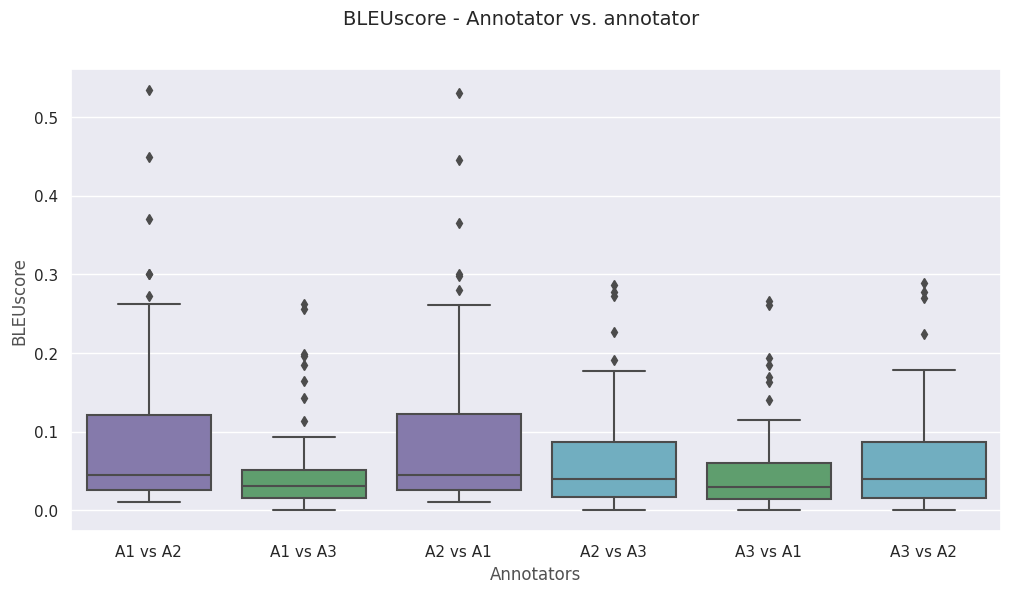

In [ ]:
blocco2_table_bleu = {#'original_id': [art["id"] for art in test_set_con_parafrasi[:50]],
          "A1 vs A2" : jj_to_tomm_bleu,
          "A1 vs A3" : jj_to_lucia_bleu,
          "A2 vs A1" : tomm_to_jj_bleu,
          "A2 vs A3" : tomm_to_lucia_bleu,
          "A3 vs A1" : lucia_to_jj_bleu,
          "A3 vs A2" : lucia_to_tomm_bleu
        }

blocco2_bleu_df = pd.DataFrame(blocco2_table_bleu)

# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('BLEUscore - Annotator vs. annotator', fontsize=14)
sns.set(style="darkgrid")
sns.boxplot(data = blocco2_bleu_df, palette=["m", "g", "m", "c", "g", "c"])
ax.set_xlabel("Annotators",size = 12,alpha=0.8)
ax.set_ylabel("BLEUscore",size = 12,alpha=0.8)

plt.show()

In [ ]:
blocco2_bleu_df

blocco2_bleu_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/2bleu.xlsx")

# BERT

In [ ]:
jj_to_tomm_bert = []
jj_to_lucia_bert = []
tomm_to_jj_bert = []
tomm_to_lucia_bert = []
lucia_to_jj_bert = []
lucia_to_tomm_bert = []
for i in range(50):
  jj_to_tomm_bert.append(bertscore.compute(predictions = [jj[i]], references = [tomm[i]], lang="it"))
  jj_to_lucia_bert.append(bertscore.compute(predictions = [jj[i]], references = [lucia[i]], lang="it"))
  tomm_to_jj_bert.append(bertscore.compute(predictions = [tomm[i]], references = [jj[i]], lang="it"))
  tomm_to_lucia_bert.append(bertscore.compute(predictions = [tomm[i]], references = [lucia[i]], lang="it"))
  lucia_to_jj_bert.append(bertscore.compute(predictions = [lucia[i]], references = [jj[i]], lang="it"))
  lucia_to_tomm_bert.append(bertscore.compute(predictions = [lucia[i]], references = [tomm[i]], lang="it"))

In [ ]:
for i in range(50):
  del jj_to_tomm_bert[i]['hashcode']
  del jj_to_lucia_bert[i]['hashcode']
  del tomm_to_jj_bert[i]['hashcode']
  del tomm_to_lucia_bert[i]['hashcode']
  del lucia_to_jj_bert[i]['hashcode']
  del lucia_to_tomm_bert[i]['hashcode']

In [ ]:
blocco2_bert_table = []
for i in range(50):
  for key in jj_to_tomm_bert[i]:
    blocco2_bert_table.append({"scoreType" : key,
                    "scoreValue" : jj_to_tomm_bert[i][key][0],
                    "annotators" : "A1 vs A2"
                    })
  for key in jj_to_lucia_bert[i]:
    blocco2_bert_table.append({"scoreType" : key,
                    "scoreValue" : jj_to_lucia_bert[i][key][0],
                    "annotators" : "A1 vs A3"
                    })
  for key in tomm_to_jj_bert[i]:
    blocco2_bert_table.append({"scoreType" : key,
                    "scoreValue" : tomm_to_jj_bert[i][key][0],
                    "annotators" : "A2 vs A1"
                    })
  for key in tomm_to_lucia_bert[i]:
    blocco2_bert_table.append({"scoreType" : key,
                    "scoreValue" : tomm_to_lucia_bert[i][key][0],
                    "annotators" : "A2 vs A3"
                    })
  for key in lucia_to_jj_bert[i]:
    blocco2_bert_table.append({"scoreType" : key,
                    "scoreValue" : lucia_to_jj_bert[i][key][0],
                    "annotators" : "A3 vs A1"
                    })
  for key in lucia_to_tomm_bert[i]:
    blocco2_bert_table.append({"scoreType" : key,
                    "scoreValue" : lucia_to_tomm_bert[i][key][0],
                    "annotators" : "A3 vs A2"
                    })

Text(0, 0.5, 'BERTscore')

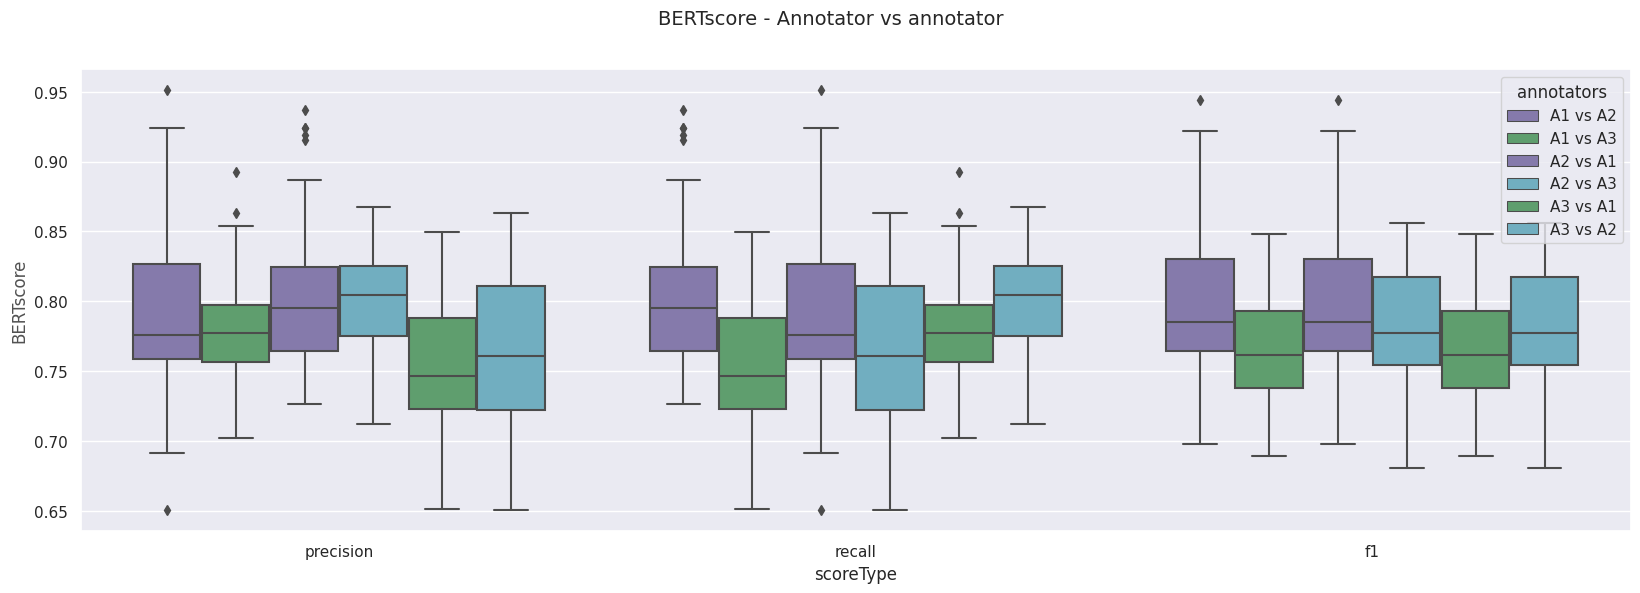

In [ ]:
blocco2_bert_df = pd.DataFrame(blocco2_bert_table)
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(20, 6))
f.suptitle('BERTscore - Annotator vs annotator', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco2_bert_df, x = "scoreType", y = "scoreValue", hue="annotators", palette=["m", "g", "m", "c", "g", "c"])
ax.set_ylabel("BERTscore",size = 12,alpha=0.8)

In [ ]:
blocco2_bert_better_table = {
    "A1 vs A2 precision" : [row["precision"][0] for row in jj_to_tomm_bert],
    "A1 vs A2 recall" : [row["recall"][0] for row in jj_to_tomm_bert],
    "A1 vs A2 f1" : [row["f1"][0] for row in jj_to_tomm_bert],

    "A1 vs A3 precision" : [row["precision"][0] for row in jj_to_lucia_bert],
    "A1 vs A3 recall" : [row["recall"][0] for row in jj_to_lucia_bert],
    "A1 vs A3 f1" : [row["f1"][0] for row in jj_to_lucia_bert],

    "A2 vs A1 precision" : [row["precision"][0] for row in tomm_to_jj_bert],
    "A2 vs A1 recall" : [row["recall"][0] for row in tomm_to_jj_bert],
    "A2 vs A1 f1" : [row["f1"][0] for row in tomm_to_jj_bert],

    "A2 vs A3 precision" : [row["precision"][0] for row in tomm_to_lucia_bert],
    "A2 vs A3 recall" : [row["recall"][0] for row in tomm_to_lucia_bert],
    "A2 vs A3 f1" : [row["f1"][0] for row in tomm_to_lucia_bert],

    "A3 vs A1 precision" : [row["precision"][0] for row in lucia_to_jj_bert],
    "A3 vs A1 recall" : [row["recall"][0] for row in lucia_to_jj_bert],
    "A3 vs A1 f1" : [row["f1"][0] for row in lucia_to_jj_bert],

    "A3 vs A2 precision" : [row["precision"][0] for row in lucia_to_tomm_bert],
    "A3 vs A2 recall" : [row["recall"][0] for row in lucia_to_tomm_bert],
    "A3 vs A2 f1" : [row["f1"][0] for row in lucia_to_tomm_bert]
}

In [ ]:
blocco2_bert_better_df = pd.DataFrame(blocco2_bert_better_table)
blocco2_bert_better_df

blocco2_bert_better_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/2bert.xlsx")

# ROUGE

In [ ]:
jj_to_tomm_rouge = []
jj_to_lucia_rouge = []
tomm_to_jj_rouge = []
tomm_to_lucia_rouge = []
lucia_to_jj_rouge = []
lucia_to_tomm_rouge = []
for i in range(50):
  jj_to_tomm_rouge.append(rouge.compute(predictions = [jj[i]], references = [tomm[i]]))
  jj_to_lucia_rouge.append(rouge.compute(predictions = [jj[i]], references = [lucia[i]]))
  tomm_to_jj_rouge.append(rouge.compute(predictions = [tomm[i]], references = [jj[i]]))
  tomm_to_lucia_rouge.append(rouge.compute(predictions = [tomm[i]], references = [lucia[i]]))
  lucia_to_jj_rouge.append(rouge.compute(predictions = [lucia[i]], references = [jj[i]]))
  lucia_to_tomm_rouge.append(rouge.compute(predictions = [lucia[i]], references = [tomm[i]]))

In [ ]:
blocco2_rouge_table = []
for i in range(50):
  for key in jj_to_tomm_rouge[i]:
    blocco2_rouge_table.append({"scoreType" : key,
                    "scoreValue" : jj_to_tomm_rouge[i][key],
                    "annotators" : "A1 vs A2"
                    })
  for key in jj_to_lucia_rouge[i]:
    blocco2_rouge_table.append({"scoreType" : key,
                    "scoreValue" : jj_to_lucia_rouge[i][key],
                    "annotators" : "A1 vs A3"
                    })
  for key in tomm_to_jj_rouge[i]:
    blocco2_rouge_table.append({"scoreType" : key,
                    "scoreValue" : tomm_to_jj_rouge[i][key],
                    "annotators" : "A2 vs A1"
                    })
  for key in tomm_to_lucia_rouge[i]:
    blocco2_rouge_table.append({"scoreType" : key,
                    "scoreValue" : tomm_to_lucia_rouge[i][key],
                    "annotators" : "A2 vs A3"
                    })
  for key in lucia_to_jj_rouge[i]:
    blocco2_rouge_table.append({"scoreType" : key,
                    "scoreValue" : lucia_to_jj_rouge[i][key],
                    "annotators" : "A3 vs A1"
                    })
  for key in lucia_to_tomm_rouge[i]:
    blocco2_rouge_table.append({"scoreType" : key,
                    "scoreValue" : lucia_to_tomm_rouge[i][key],
                    "annotators" : "A3 vs A2"
                    })

Text(0, 0.5, 'ROUGEscore')

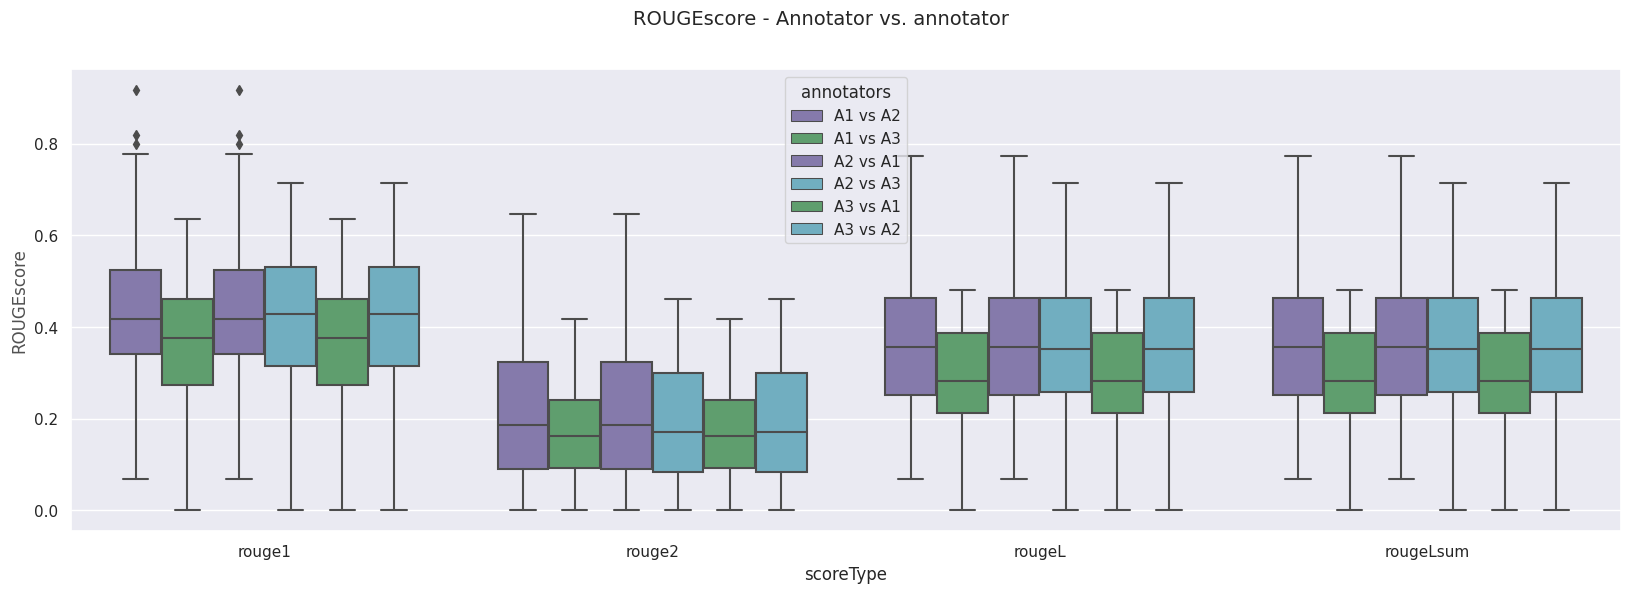

In [ ]:
blocco2_rouge_df = pd.DataFrame(blocco2_rouge_table)
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(20, 6))
f.suptitle('ROUGEscore - Annotator vs. annotator', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco2_rouge_df, x = "scoreType", y = "scoreValue", hue="annotators", palette=["m", "g", "m", "c", "g", "c"])
ax.set_ylabel("ROUGEscore",size = 12,alpha=0.8)

In [ ]:
blocco2_rouge_better_table = {
    "A1 vs A2 rouge1" : [row["rouge1"] for row in jj_to_tomm_rouge],
    "A1 vs A2 rouge2" : [row["rouge2"] for row in jj_to_tomm_rouge],
    "A1 vs A2 rougeL" : [row["rougeL"] for row in jj_to_tomm_rouge],
    "A1 vs A2 rougeLsum" : [row["rougeLsum"] for row in jj_to_tomm_rouge],

    "A1 vs A3 rouge1" : [row["rouge1"] for row in jj_to_lucia_rouge],
    "A1 vs A3 rouge2" : [row["rouge2"] for row in jj_to_lucia_rouge],
    "A1 vs A3 rougeL" : [row["rougeL"] for row in jj_to_lucia_rouge],
    "A1 vs A3 rougeLsum" : [row["rougeLsum"] for row in jj_to_lucia_rouge],

    "A2 vs A1 rouge1" : [row["rouge1"] for row in tomm_to_jj_rouge],
    "A2 vs A1 rouge2" : [row["rouge2"] for row in tomm_to_jj_rouge],
    "A2 vs A1 rougeL" : [row["rougeL"] for row in tomm_to_jj_rouge],
    "A2 vs A1 rougeLsum" : [row["rougeLsum"] for row in tomm_to_jj_rouge],

    "A2 vs A3 rouge1" : [row["rouge1"] for row in tomm_to_lucia_rouge],
    "A2 vs A3 rouge2" : [row["rouge2"] for row in tomm_to_lucia_rouge],
    "A2 vs A3 rougeL" : [row["rougeL"] for row in tomm_to_lucia_rouge],
    "A2 vs A3 rougeLsum" : [row["rougeLsum"] for row in tomm_to_lucia_rouge],

    "A3 vs A1 rouge1" : [row["rouge1"] for row in lucia_to_jj_rouge],
    "A3 vs A1 rouge2" : [row["rouge2"] for row in lucia_to_jj_rouge],
    "A3 vs A1 rougeL" : [row["rougeL"] for row in lucia_to_jj_rouge],
    "A3 vs A1 rougeLsum" : [row["rougeLsum"] for row in lucia_to_jj_rouge],

    "A3 vs A2 rouge1" : [row["rouge1"] for row in lucia_to_tomm_rouge],
    "A3 vs A2 rouge2" : [row["rouge2"] for row in lucia_to_tomm_rouge],
    "A3 vs A2 rougeL" : [row["rougeL"] for row in lucia_to_tomm_rouge],
    "A3 vs A2 rougeLsum" : [row["rougeLsum"] for row in lucia_to_tomm_rouge]
}

In [ ]:
blocco2_rouge_better_df = pd.DataFrame(blocco2_rouge_better_table)
blocco2_rouge_better_df
blocco2_rouge_better_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/2rouge.xlsx")

# **BLOCCO 3**
notazioni macchina verso originale TUTTO TESTSET

In [ ]:
dataset_file = open("/content/gdrive/MyDrive/Jacopo/exp_chatGPT/gpt_5perstatement.json")
gpt_par = json.load(dataset_file)
dataset_file.close()
dataset_file = open("/content/gdrive/MyDrive/Jacopo/exp_MT5/test_paraphrases.json")
mt5_par = json.load(dataset_file)
dataset_file.close()
dataset_file = open("/content/gdrive/MyDrive/Jacopo/exp_camoscio/test_set_camoscio.json")
camoscio_par = json.load(dataset_file)
dataset_file.close()

In [ ]:
mt5_par[0]

In [ ]:
## faccio convergere i test set parafrasi al mio formato: lista a gruppi di 5
new_mt5 = [art["paraphrases"] for art in mt5_par]
mt5_par = new_mt5

# create embeddings
execute at your own risk

In [ ]:
original_full_embeddings = [model.encode(original["statement"]) for original in test_set_con_parafrasi]

In [ ]:
gpt_embeddings = []
for index in range(len(gpt_par)):
  gpt_embeddings.append([model.encode(parafrasi) for parafrasi in gpt_par[index]])

In [ ]:
mt5_embeddings = []
for index in range(len(mt5_par)):
  mt5_embeddings.append([model.encode(parafrasi) for parafrasi in mt5_par[index]])

In [ ]:
camoscio_embeddings = []
for index in range(len(camoscio_par)):
  camoscio_embeddings.append([model.encode(parafrasi) for parafrasi in camoscio_par[index]["par"]])

In [ ]:
#with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/original_full_embeddings.npy", "wb") as F:
#    np.save(F, original_full_embeddings)
#with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/gpt_embeddings.npy", "wb") as F:
#    np.save(F, gpt_embeddings)
#with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/mt5_embeddings.npy", "wb") as F:
#    np.save(F, mt5_embeddings)
#with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/camoscio_embeddings.npy", "wb") as F:
#    np.save(F, camoscio_embeddings)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


to read it back:


```
with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/mt5_embeddings.npy", "rb") as F:
   a = np.load(F)
```



# cosine similarity

In [ ]:
with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/original_full_embeddings.npy", "rb") as F:
   original_full_embeddings = np.load(F)

In [ ]:
with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/gpt_embeddings.npy", "rb") as F:
   gpt_embeddings = np.load(F)

blocco3_gpt = []
for index in range(len(test_set_con_parafrasi)):
  blocco3_gpt.append(
      cosine_similarity(
        [original_full_embeddings[index]],
        gpt_embeddings[index]
      )[0]
  )

In [ ]:
with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/mt5_embeddings.npy", "rb") as F:
   mt5_embeddings = np.load(F)

blocco3_mt5 = []
for index in range(len(test_set_con_parafrasi)):
  blocco3_mt5.append(
      cosine_similarity(
        [original_full_embeddings[index]],
        mt5_embeddings[index]
      )[0]
  )

In [ ]:
mean(cosine_similarity(
        [original_full_embeddings[0]],
        mt5_embeddings[0]
      )[0])
# to be sure I am using the function correctly

0.9665507

In [ ]:
with open("/content/gdrive/MyDrive/Jacopo/generate_paraphrases/embeddings/camoscio_embeddings.npy", "rb") as F:
   camoscio_embeddings = np.load(F, allow_pickle=True)

blocco3_camoscio = []
for j in range(len(test_set_con_parafrasi)):
  for i in range(len(camoscio_par)):
    if camoscio_par[i]["id"] == test_set_con_parafrasi[j]["id"]:
      blocco3_camoscio.append(
          cosine_similarity(
            [original_full_embeddings[j]],
            camoscio_embeddings[i]
          )[0]
      )

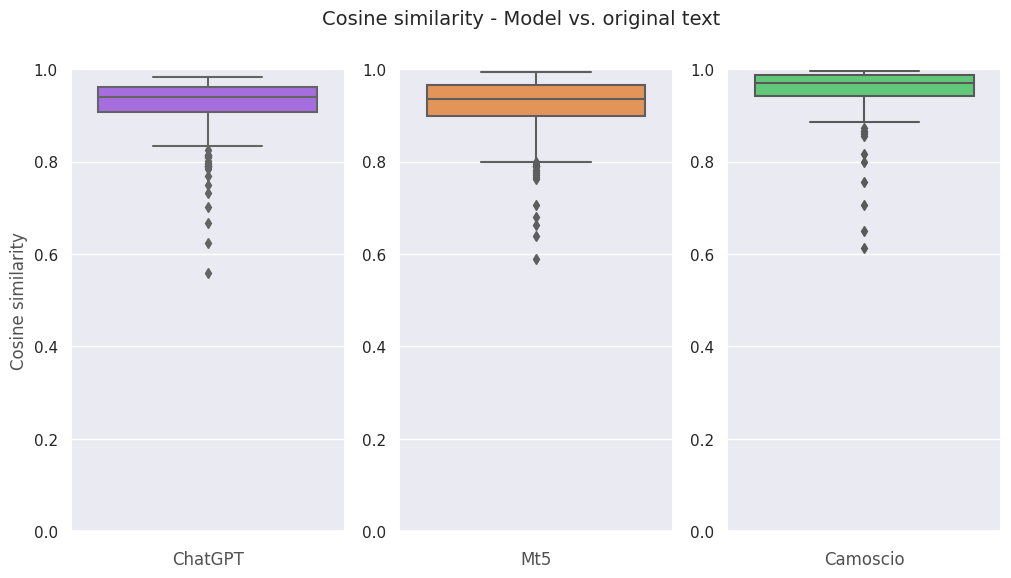

In [ ]:
f, (ax) = plt.subplots(1, 3, figsize=(12, 6))
f.suptitle('Cosine similarity - Model vs. original text', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = [mean(row) for row in blocco3_gpt], ax=ax[0],  color = "#a65af2")
ax[0].set_xlabel("ChatGPT",size = 12,alpha=0.8)
ax[0].set_ylabel("Cosine similarity",size = 12,alpha=0.8)

sns.boxplot(data = [mean(row) for row in blocco3_mt5], ax=ax[1], color = "#fa9141")
ax[1].set_xlabel("Mt5",size = 12,alpha=0.8)
ax[1].set_xticklabels([])

sns.boxplot(data = [mean(row) for row in blocco3_camoscio], ax=ax[2], color = "#50d971")
ax[2].set_xlabel("Camoscio",size = 12,alpha=0.8)
ax[2].set_xticklabels([])

for a in ax:
  a.set(ylim=(0, 1))
  a.set_xticklabels([])

plt.show()

In [ ]:
blocco3_camoscio_na = []
blocco3_camoscio_max = []
blocco3_camoscio_min = []
for j in range(len(test_set_con_parafrasi)):
  article_present_in_camoscio = False
  for i in range(len(camoscio_par)):
    if camoscio_par[i]["id"] == test_set_con_parafrasi[j]["id"]:
      blocco3_camoscio_na.append(
          mean(cosine_similarity(
            [original_full_embeddings[j]],
            camoscio_embeddings[i]
          )[0])
        )
      blocco3_camoscio_max.append(
          max(cosine_similarity(
            [original_full_embeddings[j]],
            camoscio_embeddings[i]
          )[0])
        )
      blocco3_camoscio_min.append(
          min(cosine_similarity(
            [original_full_embeddings[j]],
            camoscio_embeddings[i]
          )[0])
        )
      article_present_in_camoscio = True
  if not article_present_in_camoscio:
    blocco3_camoscio_na.append("n/a")
    blocco3_camoscio_max.append("n/a")
    blocco3_camoscio_min.append("n/a")

blocco3_cosine_table = {
    "ChatGPT mean" : [mean(row) for row in blocco3_gpt],
    "ChatGPT max" : [max(row) for row in blocco3_gpt],
    "ChatGPT min" : [min(row) for row in blocco3_gpt],
    "Mt5 mean" : [mean(row) for row in blocco3_mt5],
    "Mt5 max" : [max(row) for row in blocco3_mt5],
    "Mt5 min" : [min(row) for row in blocco3_mt5],
    "Camoscio mean" : blocco3_camoscio_na,
    "Camoscio max" : blocco3_camoscio_max,
    "Camoscio min" : blocco3_camoscio_min
}
blocco3_cosin_df = pd.DataFrame(blocco3_cosine_table)
blocco3_cosin_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/3cosine.xlsx")

blocco3_cosin_df

,ChatGPT mean,ChatGPT max,ChatGPT min,Mt5 mean,Mt5 max,Mt5 min,Camoscio mean,Camoscio max,Camoscio min
0,0.814589,0.974612,0.763751,0.966551,0.977937,0.950705,n/a,n/a,n/a
1,0.936008,0.956586,0.918064,0.893003,0.898917,0.885425,n/a,n/a,n/a
2,0.958185,0.974776,0.942873,0.817124,0.981507,0.755815,0.966689,0.966689,0.966689
3,0.971172,0.980405,0.960801,0.899201,0.929995,0.853445,0.994437,0.994437,0.994437
4,0.932884,0.976234,0.854299,0.933448,0.982278,0.896730,n/a,n/a,n/a
...,...,...,...,...,...,...,...,...,...
353,0.906413,0.932204,0.881632,0.937647,0.937951,0.936985,n/a,n/a,n/a
354,0.955115,0.988335,0.894288,0.978997,0.992315,0.966261,n/a,n/a,n/a
355,0.940182,0.944908,0.936120,0.931906,0.957555,0.893333,0.966038,0.966038,0.966038
356,0.971268,0.977286,0.963424,0.932355,0.971167,0.835566,n/a,n/a,n/a


# bleu

In [ ]:
blocco3_gpt_bleu = []
for index in range(len(test_set_con_parafrasi)):
  blocco3_gpt_bleu.append(
      [
          bleu(test_set_con_parafrasi[index]["statement"], gpt_par[index][0]),
          bleu(test_set_con_parafrasi[index]["statement"], gpt_par[index][1]),
          bleu(test_set_con_parafrasi[index]["statement"], gpt_par[index][2]),
          bleu(test_set_con_parafrasi[index]["statement"], gpt_par[index][3]),
          bleu(test_set_con_parafrasi[index]["statement"], gpt_par[index][4])
       ]
      )

In [ ]:
blocco3_mt5_bleu = []
for index in range(len(test_set_con_parafrasi)):
  blocco3_mt5_bleu.append(
      [
          bleu(test_set_con_parafrasi[index]["statement"], mt5_par[index][0]),
          bleu(test_set_con_parafrasi[index]["statement"], mt5_par[index][1]),
          bleu(test_set_con_parafrasi[index]["statement"], mt5_par[index][2]),
          bleu(test_set_con_parafrasi[index]["statement"], mt5_par[index][3]),
          bleu(test_set_con_parafrasi[index]["statement"], mt5_par[index][4])
       ]
      )

In [ ]:
blocco3_camoscio_bleu = []

for j in range(len(test_set_con_parafrasi)):
  for i in range(len(camoscio_par)):
    if camoscio_par[i]["id"] == test_set_con_parafrasi[j]["id"]:
      if len(camoscio_par[i]["par"]) == 1:
        blocco3_camoscio_bleu.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0])])
      elif len(camoscio_par[i]["par"]) == 2:
        blocco3_camoscio_bleu.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][1])])
      elif len(camoscio_par[i]["par"]) == 3:
        blocco3_camoscio_bleu.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][1]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][2])])
      elif len(camoscio_par[i]["par"]) == 4:
        blocco3_camoscio_bleu.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][1]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][2]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][3])])
      elif len(camoscio_par[i]["par"]) == 5:
        blocco3_camoscio_bleu.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][1]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][2]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][3]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][4])])

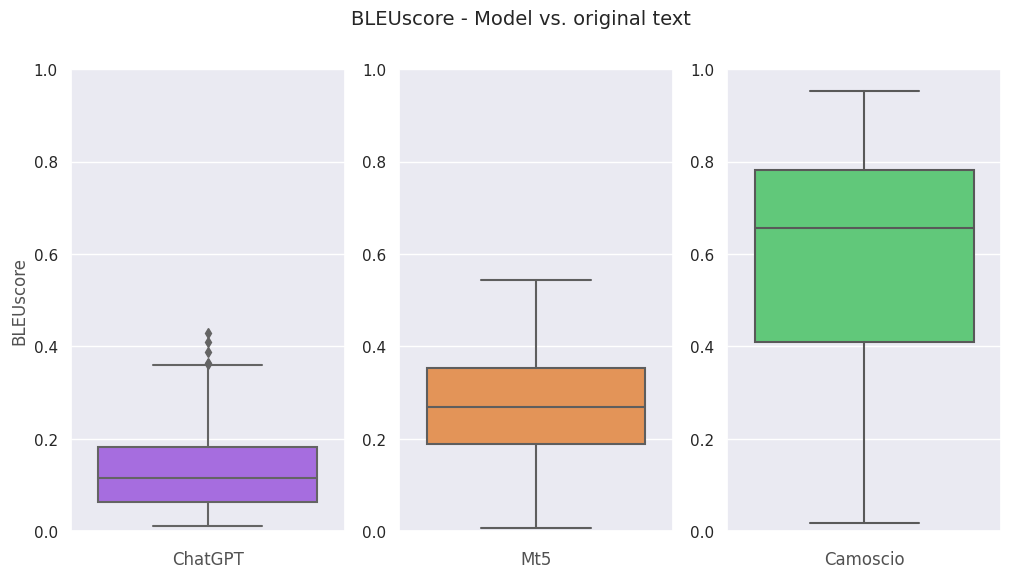

In [ ]:
f, (ax) = plt.subplots(1, 3, figsize=(12, 6))
f.suptitle('BLEUscore - Model vs. original text', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = [mean(parafrasi) for parafrasi in blocco3_gpt_bleu] , ax=ax[0], color = "#a65af2")
ax[0].set_xlabel("ChatGPT",size = 12,alpha=0.8)
ax[0].set_ylabel("BLEUscore",size = 12,alpha=0.8)

sns.boxplot(data = [mean(parafrasi) for parafrasi in blocco3_mt5_bleu] , ax=ax[1], color = "#fa9141")
ax[1].set_xlabel("Mt5",size = 12,alpha=0.8)

sns.boxplot(data = [mean(parafrasi) for parafrasi in blocco3_camoscio_bleu], ax=ax[2], color = "#50d971")
ax[2].set_xlabel("Camoscio",size = 12,alpha=0.8)


for a in ax:
  a.set(ylim=(0, 1))
  a.set_xticklabels([])

plt.show()

Text(0, 0.5, 'BLEUscore')

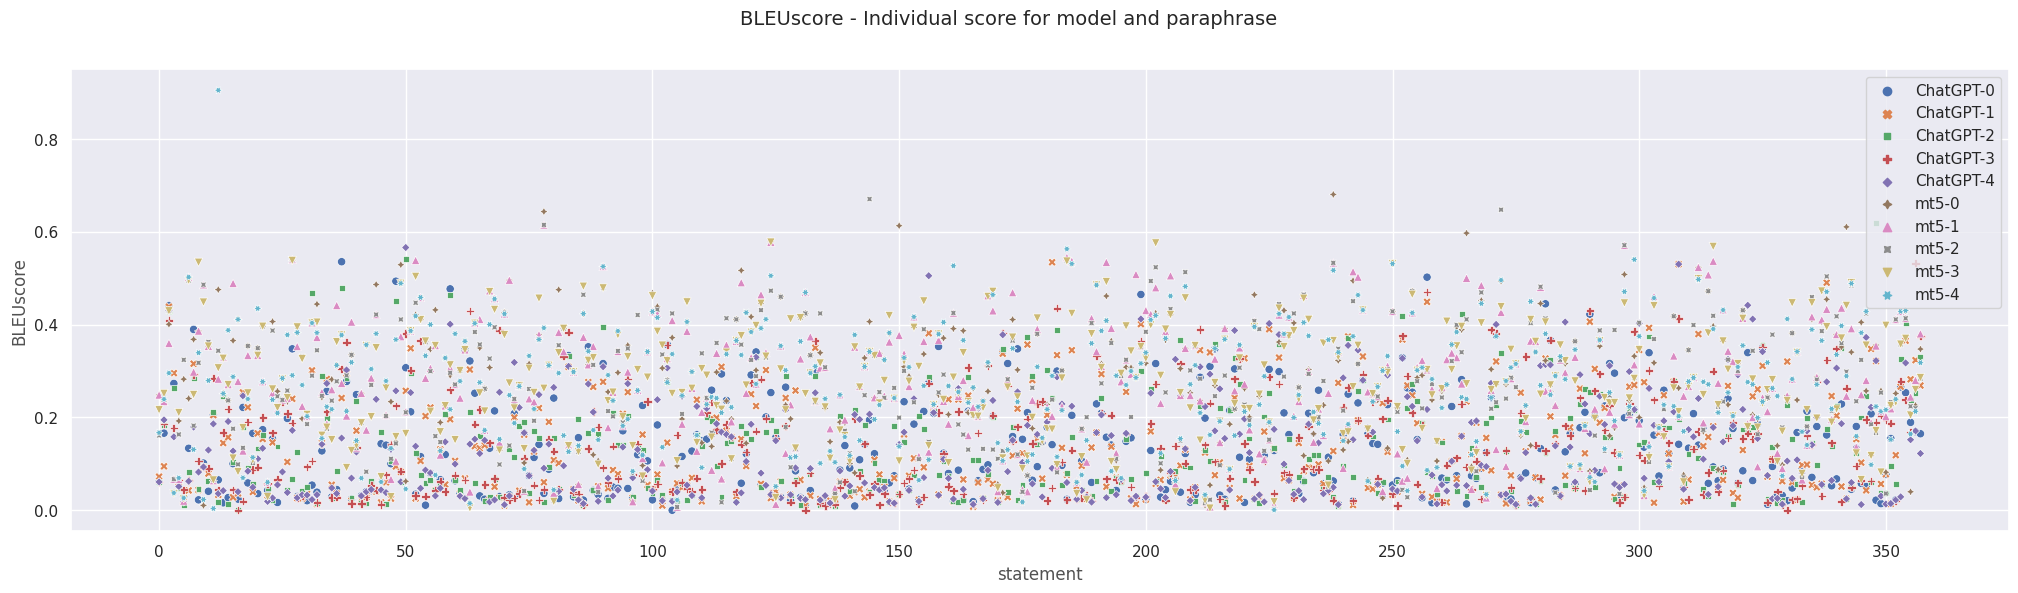

In [ ]:
blocco3_bleu_table = {
    "ChatGPT-0": [par[0] for par in blocco3_gpt_bleu],
    "ChatGPT-1": [par[1] for par in blocco3_gpt_bleu],
    "ChatGPT-2": [par[2] for par in blocco3_gpt_bleu],
    "ChatGPT-3": [par[3] for par in blocco3_gpt_bleu],
    "ChatGPT-4": [par[4] for par in blocco3_gpt_bleu],
    "mt5-0" : [par[0] for par in blocco3_mt5_bleu],
    "mt5-1" : [par[1] for par in blocco3_mt5_bleu],
    "mt5-2" : [par[2] for par in blocco3_mt5_bleu],
    "mt5-3" : [par[3] for par in blocco3_mt5_bleu],
    "mt5-4" : [par[4] for par in blocco3_mt5_bleu]
}

blocco3_bleu_df = pd.DataFrame(blocco3_bleu_table)

f, (ax) = plt.subplots(1, 1, figsize=(25, 6))
f.suptitle('BLEUscore - Individual score for model and paraphrase', fontsize=14)

sns.set(style="darkgrid")
sns.scatterplot(data = blocco3_bleu_df)
ax.set_xlabel("statement",size = 12,alpha=0.8)
ax.set_ylabel("BLEUscore",size = 12,alpha=0.8)

In [ ]:
blocco3_camoscio_bleu_na = []
for j in range(len(test_set_con_parafrasi)):
  article_present_in_camoscio = False
  for i in range(len(camoscio_par)):
    if camoscio_par[i]["id"] == test_set_con_parafrasi[j]["id"]:

      if len(camoscio_par[i]["par"]) == 1:
        blocco3_camoscio_bleu_na.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0])])
      elif len(camoscio_par[i]["par"]) == 2:
        blocco3_camoscio_bleu_na.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][1])])
      elif len(camoscio_par[i]["par"]) == 3:
        blocco3_camoscio_bleu_na.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][1]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][2])])
      elif len(camoscio_par[i]["par"]) == 4:
        blocco3_camoscio_bleu_na.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][1]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][2]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][3])])
      elif len(camoscio_par[i]["par"]) == 5:
        blocco3_camoscio_bleu_na.append([bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][0]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][1]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][2]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][3]),
                                 bleu(test_set_con_parafrasi[j]["statement"], camoscio_par[i]["par"][4])])
      article_present_in_camoscio = True
  if not article_present_in_camoscio:
    blocco3_camoscio_bleu_na.append("n/a")

blocco3_camoscio_bleu_mean = []
blocco3_camoscio_bleu_max = []
blocco3_camoscio_bleu_min = []
for el in blocco3_camoscio_bleu_na:
  if(el != "n/a"):
    blocco3_camoscio_bleu_mean.append(mean(el))
    blocco3_camoscio_bleu_max.append(max(el))
    blocco3_camoscio_bleu_min.append(min(el))
  else:
    blocco3_camoscio_bleu_mean.append("n/a")
    blocco3_camoscio_bleu_max.append("n/a")
    blocco3_camoscio_bleu_min.append("n/a")

blocco3_bleu_table = {
    "ChatGPT mean" : [mean(row) for row in blocco3_gpt_bleu],
    "ChatGPT max" : [max(row) for row in blocco3_gpt_bleu],
    "ChatGPT min" : [min(row) for row in blocco3_gpt_bleu],
    "Mt5 mean" : [mean(row) for row in blocco3_mt5_bleu],
    "Mt5 max" : [max(row) for row in blocco3_mt5_bleu],
    "Mt5 min" : [min(row) for row in blocco3_mt5_bleu],
    "Camoscio mean" : blocco3_camoscio_bleu_mean,
    "Camoscio max" : blocco3_camoscio_bleu_max,
    "Camoscio min" : blocco3_camoscio_bleu_min
}
blocco3_bleu_df = pd.DataFrame(blocco3_bleu_table)

blocco3_bleu_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/3bleu.xlsx")

blocco3_bleu_df

,ChatGPT mean,ChatGPT max,ChatGPT min,Mt5 mean,Mt5 max,Mt5 min,Camoscio mean,Camoscio max,Camoscio min
0,0.063320,0.072398,0.061050,0.208278,0.248414,0.161105,n/a,n/a,n/a
1,0.164843,0.194742,0.094642,0.242219,0.251685,0.234219,n/a,n/a,n/a
2,0.429669,0.440993,0.408564,0.382968,0.429514,0.295504,0.359446,0.359446,0.359446
3,0.233439,0.295408,0.158112,0.054985,0.067146,0.036175,0.829043,0.829043,0.829043
4,0.056965,0.065240,0.047253,0.140475,0.210341,0.066675,n/a,n/a,n/a
...,...,...,...,...,...,...,...,...,...
353,0.233064,0.326413,0.028891,0.400180,0.428495,0.357709,n/a,n/a,n/a
354,0.315367,0.402767,0.238195,0.411612,0.430377,0.370273,n/a,n/a,n/a
355,0.205910,0.282138,0.151932,0.175433,0.244133,0.039807,0.844366,0.844366,0.844366
356,0.289704,0.532425,0.169252,0.239744,0.280116,0.213099,n/a,n/a,n/a


# BERT

# creation of scores, execute ony if something has changed

In [ ]:
blocco3_gpt_bert = []
blocco3_mt5_bert = []
for i in range(len(test_set_con_parafrasi)):
  blocco3_gpt_bert.append(bertscore.compute(predictions = gpt_par[i], references = [test_set_con_parafrasi[i]["statement"], test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"]], lang="it"))
  blocco3_mt5_bert.append(bertscore.compute(predictions = mt5_par[i], references = [test_set_con_parafrasi[i]["statement"], test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"]], lang="it"))

In [ ]:
blocco3_camoscio_bert = []
for j in range(len(test_set_con_parafrasi)):
  for i in range(len(camoscio_par)):
    if camoscio_par[i]["id"] == test_set_con_parafrasi[j]["id"]:
      statement_copies = []
      for numero_parafrasi in camoscio_par[i]["par"]:
        statement_copies.append(test_set_con_parafrasi[j]["statement"])
      blocco3_camoscio_bert.append(bertscore.compute(predictions = camoscio_par[i]["par"], references = statement_copies, lang="it"))

In [ ]:
#with open("/content/gdrive/MyDrive/Jacopo/exp_chatGPT/scores/blocco3_bert.npy", "wb") as F:
#    np.save(F, blocco3_gpt_bert)
#with open("/content/gdrive/MyDrive/Jacopo/exp_MT5/scores/blocco3_bert.npy", "wb") as F:
#    np.save(F, blocco3_mt5_bert)
#with open("/content/gdrive/MyDrive/Jacopo/exp_camoscio/scores/blocco3_bert.npy", "wb") as F:
#    np.save(F, blocco3_camoscio_bert)

#load of bert scores

In [ ]:
with open("/content/gdrive/MyDrive/Jacopo/exp_chatGPT/scores/blocco3_bert.npy", "rb") as F:
    blocco3_gpt_bert = np.load(F, allow_pickle=True)
with open("/content/gdrive/MyDrive/Jacopo/exp_MT5/scores/blocco3_bert.npy", "rb") as F:
    blocco3_mt5_bert = np.load(F, allow_pickle=True)
with open("/content/gdrive/MyDrive/Jacopo/exp_camoscio/scores/blocco3_bert.npy", "rb") as F:
    blocco3_camoscio_bert = np.load(F, allow_pickle=True)

In [ ]:
blocco3_camoscio_bert[2]

In [ ]:
for i in range(len(test_set_con_parafrasi)):
    del blocco3_gpt_bert[i]['hashcode']
    del blocco3_mt5_bert[i]['hashcode']
for i in range(len(camoscio_par)):
    del blocco3_camoscio_bert[i]['hashcode']

In [ ]:
blocco3_bert_table = []
for i in range(len(test_set_con_parafrasi)):
  for key in blocco3_gpt_bert[i]:
    blocco3_bert_table.append({"scoreType" : key,
                  "scoreValue" : mean(blocco3_gpt_bert[i][key]),
                    "model" : "ChatGPT"
                    })
  for key in blocco3_mt5_bert[i]:
    blocco3_bert_table.append({"scoreType" : key,
                    "scoreValue" : mean(blocco3_mt5_bert[i][key]),
                    "model" : "mt5"
                    })
  if( i < len(camoscio_par)):
    for key in blocco3_camoscio_bert[i]:
      blocco3_bert_table.append({"scoreType" : key,
                      "scoreValue" : mean(blocco3_camoscio_bert[i][key]),
                      "model" : "camoscio"
                      })

Text(0, 0.5, 'BERTscore')

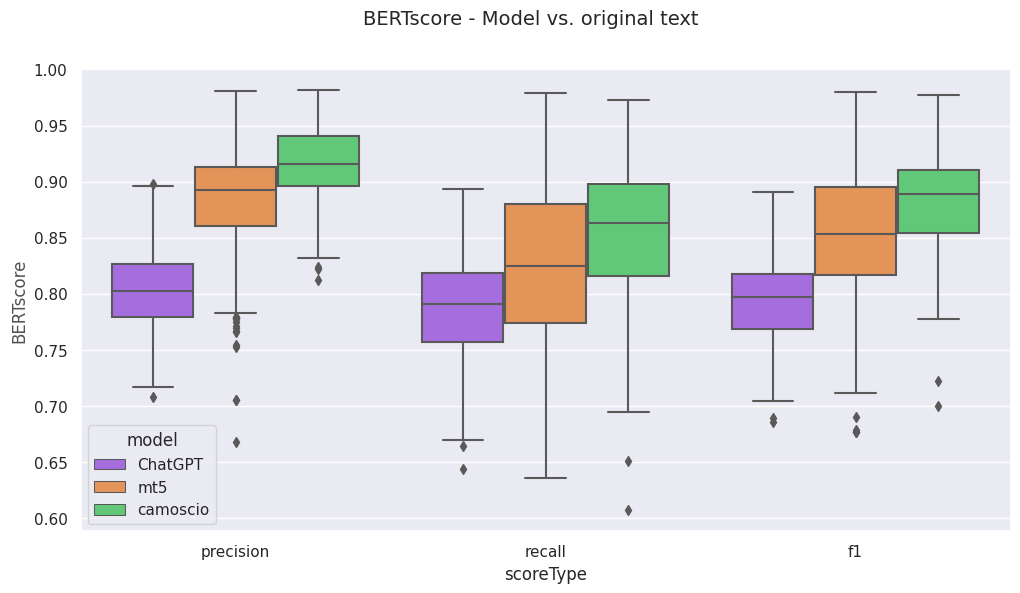

In [ ]:
blocco3_bert_df = pd.DataFrame(blocco3_bert_table)
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('BERTscore - Model vs. original text', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco3_bert_df, x = "scoreType", y = "scoreValue", hue="model", palette=["#a65af2", "#fa9141", "#50d971"])
ax.set_ylabel("BERTscore",size = 12,alpha=0.8)

In [ ]:
# different approach, siccome gli score tra bleu, bert e rouge sono presenti sempre per gli stessi articoli
# creo una mask che mi dice "in questo articolo camoscio ha un punteggio"

camoscio_mask = []
for index in range(len(test_set_con_parafrasi)):
  if blocco3_camoscio_na[index] != "n/a":
    camoscio_mask.append(True)
  else:
    camoscio_mask.append(False)

last_camoscio_value_used = 0
blocco3_camoscio_bert_na = []
blocco3_camoscio_bert_max = []
blocco3_camoscio_bert_min = []
for index in range(len(test_set_con_parafrasi)):
  if(camoscio_mask[index]):
    blocco3_camoscio_bert_na.append({
        'precision' : mean(blocco3_camoscio_bert[last_camoscio_value_used]["precision"]),
        'recall' : mean(blocco3_camoscio_bert[last_camoscio_value_used]['recall']),
        'f1' : mean(blocco3_camoscio_bert[last_camoscio_value_used]['f1'])
    })
    blocco3_camoscio_bert_max.append({
        'precision' : max(blocco3_camoscio_bert[last_camoscio_value_used]["precision"]),
        'recall' : max(blocco3_camoscio_bert[last_camoscio_value_used]['recall']),
        'f1' : max(blocco3_camoscio_bert[last_camoscio_value_used]['f1'])
    })
    blocco3_camoscio_bert_min.append({
        'precision' : min(blocco3_camoscio_bert[last_camoscio_value_used]["precision"]),
        'recall' : min(blocco3_camoscio_bert[last_camoscio_value_used]['recall']),
        'f1' : min(blocco3_camoscio_bert[last_camoscio_value_used]['f1'])
    })
    last_camoscio_value_used += 1
  else:
    blocco3_camoscio_bert_na.append({'precision' : "n/a", "recall" : "n/a", "f1" : "n/a"})
    blocco3_camoscio_bert_max.append({'precision' : "n/a", "recall" : "n/a", "f1" : "n/a"})
    blocco3_camoscio_bert_min.append({'precision' : "n/a", "recall" : "n/a", "f1" : "n/a"})

last_camoscio_value_used == len(blocco3_camoscio_bert)

True

In [ ]:
blocco3_bert_better_table = {
    "ChatGPT precision mean" : [mean(row["precision"]) for row in blocco3_gpt_bert],
    "ChatGPT precision max" : [max(row["precision"]) for row in blocco3_gpt_bert],
    "ChatGPT precision min" : [min(row["precision"]) for row in blocco3_gpt_bert],
    "ChatGPT recall mean" : [mean(row["recall"]) for row in blocco3_gpt_bert],
    "ChatGPT recall max" : [max(row["recall"]) for row in blocco3_gpt_bert],
    "ChatGPT recall min" : [min(row["recall"]) for row in blocco3_gpt_bert],
    "ChatGPT f1 mean" : [mean(row["f1"]) for row in blocco3_gpt_bert],
    "ChatGPT f1 max" : [max(row["f1"]) for row in blocco3_gpt_bert],
    "ChatGPT f1 min" : [min(row["f1"]) for row in blocco3_gpt_bert],
    "Mt5 precision mean" : [mean(row["precision"]) for row in blocco3_mt5_bert],
    "Mt5 precision max" : [max(row["precision"]) for row in blocco3_mt5_bert],
    "Mt5 precision min" : [min(row["precision"]) for row in blocco3_mt5_bert],
    "Mt5 recall mean" : [mean(row["recall"]) for row in blocco3_mt5_bert],
    "Mt5 recall max" : [max(row["recall"]) for row in blocco3_mt5_bert],
    "Mt5 recall min" : [min(row["recall"]) for row in blocco3_mt5_bert],
    "Mt5 f1 mean" : [mean(row["f1"]) for row in blocco3_mt5_bert],
    "Mt5 f1 max" : [max(row["f1"]) for row in blocco3_mt5_bert],
    "Mt5 f1 min" : [min(row["f1"]) for row in blocco3_mt5_bert],
    "Camoscio precision mean" : [row["precision"] for row in blocco3_camoscio_bert_na],
    "Camoscio precision max" : [row["precision"] for row in blocco3_camoscio_bert_max],
    "Camoscio precision min" : [row["precision"] for row in blocco3_camoscio_bert_min],
    "Camoscio recall mean" : [row["recall"] for row in blocco3_camoscio_bert_na],
    "Camoscio recall max" : [row["recall"] for row in blocco3_camoscio_bert_max],
    "Camoscio recall min" : [row["recall"] for row in blocco3_camoscio_bert_min],
    "Camoscio f1 mean" : [row["f1"] for row in blocco3_camoscio_bert_na],
    "Camoscio f1 max" : [row["f1"] for row in blocco3_camoscio_bert_max],
    "Camoscio f1 min" : [row["f1"] for row in blocco3_camoscio_bert_min]
}
blocco3_bert_better_df = pd.DataFrame(blocco3_bert_better_table)

blocco3_bert_better_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/3bert.xlsx")

blocco3_bert_better_df

,ChatGPT precision mean,ChatGPT precision max,ChatGPT precision min,ChatGPT recall mean,ChatGPT recall max,ChatGPT recall min,ChatGPT f1 mean,ChatGPT f1 max,ChatGPT f1 min,Mt5 precision mean,...,Mt5 f1 min,Camoscio precision mean,Camoscio precision max,Camoscio precision min,Camoscio recall mean,Camoscio recall max,Camoscio recall min,Camoscio f1 mean,Camoscio f1 max,Camoscio f1 min
0,0.799781,0.818190,0.784699,0.783550,0.805968,0.773771,0.791577,0.812033,0.779197,0.851203,...,0.811753,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
1,0.805000,0.819873,0.780922,0.759178,0.761644,0.754738,0.781374,0.788006,0.767607,0.885607,...,0.816473,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
2,0.857746,0.873593,0.844195,0.835940,0.849525,0.812188,0.846675,0.861391,0.827882,0.898397,...,0.860284,0.909678,0.909678,0.909678,0.894135,0.894135,0.894135,0.901839,0.901839,0.901839
3,0.814637,0.832069,0.801625,0.799107,0.825674,0.784608,0.806780,0.828859,0.796254,0.777719,...,0.643463,0.956048,0.956048,0.956048,0.930169,0.930169,0.930169,0.942931,0.942931,0.942931
4,0.803046,0.837329,0.772297,0.814208,0.844743,0.777265,0.808581,0.841020,0.774773,0.852228,...,0.787809,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,0.835336,0.862451,0.788353,0.777289,0.800639,0.750797,0.805206,0.830396,0.769117,0.894665,...,0.844511,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
354,0.818203,0.833228,0.801712,0.780284,0.823547,0.764087,0.798596,0.819174,0.782448,0.915002,...,0.852594,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
355,0.797606,0.815377,0.769557,0.741422,0.748735,0.728185,0.768419,0.776430,0.748299,0.831174,...,0.744436,0.919904,0.919904,0.919904,0.823025,0.823025,0.823025,0.868772,0.868772,0.868772
356,0.847710,0.886408,0.793560,0.812210,0.832833,0.775445,0.829548,0.858786,0.784398,0.887465,...,0.818505,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a


# ROUGE

# creation of scores, execute ony if something has changed

In [ ]:
blocco3_gpt_rouge = []
blocco3_mt5_rouge = []
for i in range(len(test_set_con_parafrasi)):
  blocco3_gpt_rouge.append(rouge.compute(predictions = gpt_par[i], references = [test_set_con_parafrasi[i]["statement"], test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"]],use_aggregator=False))
  blocco3_mt5_rouge.append(rouge.compute(predictions = mt5_par[i], references = [test_set_con_parafrasi[i]["statement"], test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"],test_set_con_parafrasi[i]["statement"]],use_aggregator=False))

In [ ]:
#with open("/content/gdrive/MyDrive/Jacopo/exp_chatGPT/scores/blocco3_rouge.npy", "wb") as F:
#    np.save(F, blocco3_gpt_rouge)
#with open("/content/gdrive/MyDrive/Jacopo/exp_MT5/scores/blocco3_rouge.npy", "wb") as F:
#    np.save(F, blocco3_mt5_rouge)

In [ ]:
blocco3_camoscio_rouge = []
for i in range(len(camoscio_par)):
  for j in range(len(test_set_con_parafrasi)):
    if camoscio_par[i]["id"] == test_set_con_parafrasi[j]["id"]:
      statement_copies = []
      for numero_parafrasi in camoscio_par[i]["par"]:
        statement_copies.append(test_set_con_parafrasi[j]["statement"])
      blocco3_camoscio_rouge.append(rouge.compute(predictions = camoscio_par[i]["par"], references = statement_copies, use_aggregator=False))

In [ ]:
#with open("/content/gdrive/MyDrive/Jacopo/exp_camoscio/scores/blocco3_rouge.npy", "wb") as F:
#    np.save(F, blocco3_camoscio_rouge)

#load of rouge scores

In [ ]:
with open("/content/gdrive/MyDrive/Jacopo/exp_chatGPT/scores/blocco3_rouge.npy", "rb") as F:
    blocco3_gpt_rouge = np.load(F, allow_pickle=True)
with open("/content/gdrive/MyDrive/Jacopo/exp_MT5/scores/blocco3_rouge.npy", "rb") as F:
    blocco3_mt5_rouge = np.load(F, allow_pickle=True)
with open("/content/gdrive/MyDrive/Jacopo/exp_camoscio/scores/blocco3_rouge.npy", "rb") as F:
    blocco3_camoscio_rouge = np.load(F, allow_pickle=True)

In [ ]:
blocco3_camoscio_rouge[100]

{'rouge1': [1.0, 1.0, 1.0, 1.0, 0.962962962962963],
 'rouge2': [1.0, 1.0, 1.0, 1.0, 0.9615384615384615],
 'rougeL': [1.0, 1.0, 1.0, 1.0, 0.962962962962963],
 'rougeLsum': [1.0, 1.0, 1.0, 1.0, 0.962962962962963]}

In [ ]:
blocco3_rouge_table = []
for i in range(len(test_set_con_parafrasi)):
  for key in blocco3_gpt_rouge[i]:
    blocco3_rouge_table.append({"scoreType" : key,
                  "scoreValue" : mean(blocco3_gpt_rouge[i][key]),
                    "model" : "ChatGPT"
                    })
  for key in blocco3_mt5_rouge[i]:
    blocco3_rouge_table.append({"scoreType" : key,
                    "scoreValue" : mean(blocco3_mt5_rouge[i][key]),
                    "model" : "mt5"
                    })
  if( i < len(camoscio_par)):
    for key in blocco3_camoscio_rouge[i]:
      blocco3_rouge_table.append({"scoreType" : key,
                      "scoreValue" : mean(blocco3_camoscio_rouge[i][key]),
                      "model" : "camoscio"
                      })

Text(0, 0.5, 'ROUGEscore')

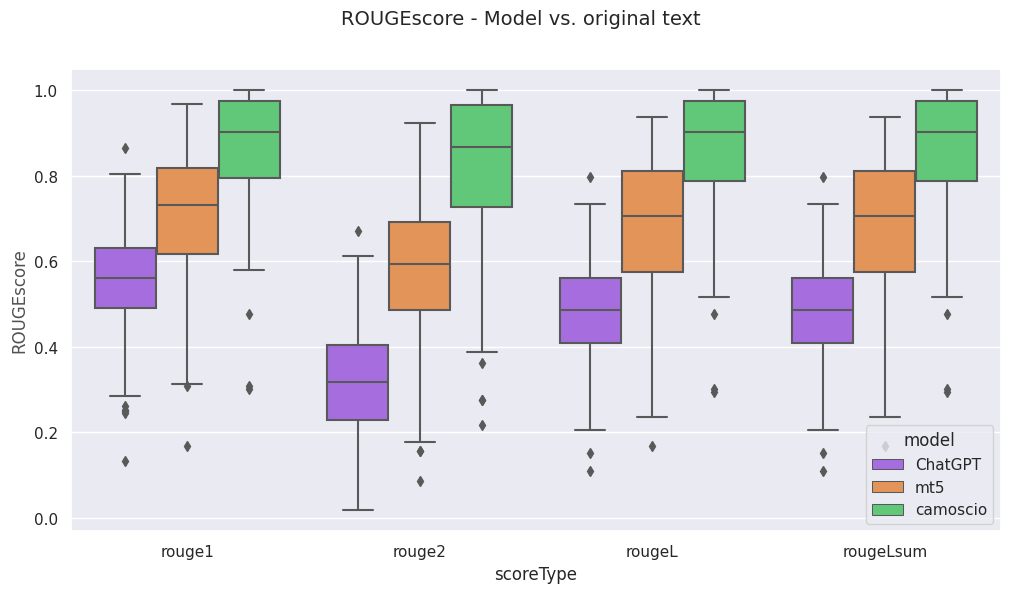

In [ ]:
blocco3_rouge_df = pd.DataFrame(blocco3_rouge_table)
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(12, 6))
f.suptitle('ROUGEscore - Model vs. original text', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco3_rouge_df, x = "scoreType", y = "scoreValue", hue="model", palette=["#a65af2", "#fa9141", "#50d971"])
ax.set_ylabel("ROUGEscore",size = 12,alpha=0.8)

In [ ]:
last_camoscio_value_used = 0
blocco3_camoscio_rouge_na = []
blocco3_camoscio_rouge_max = []
blocco3_camoscio_rouge_min = []
for index in range(len(test_set_con_parafrasi)):
  if(camoscio_mask[index]):
    blocco3_camoscio_rouge_na.append({
        'rouge1' : mean(blocco3_camoscio_rouge[last_camoscio_value_used]["rouge1"]),
        'rouge2' : mean(blocco3_camoscio_rouge[last_camoscio_value_used]['rouge2']),
        'rougeL' : mean(blocco3_camoscio_rouge[last_camoscio_value_used]['rougeL']),
        'rougeLsum' : mean(blocco3_camoscio_rouge[last_camoscio_value_used]['rougeLsum'])
    })
    blocco3_camoscio_rouge_max.append({
        'rouge1' : max(blocco3_camoscio_rouge[last_camoscio_value_used]["rouge1"]),
        'rouge2' : max(blocco3_camoscio_rouge[last_camoscio_value_used]['rouge2']),
        'rougeL' : max(blocco3_camoscio_rouge[last_camoscio_value_used]['rougeL']),
        'rougeLsum' : max(blocco3_camoscio_rouge[last_camoscio_value_used]['rougeLsum'])
    })
    blocco3_camoscio_rouge_min.append({
        'rouge1' : min(blocco3_camoscio_rouge[last_camoscio_value_used]["rouge1"]),
        'rouge2' : min(blocco3_camoscio_rouge[last_camoscio_value_used]['rouge2']),
        'rougeL' : min(blocco3_camoscio_rouge[last_camoscio_value_used]['rougeL']),
        'rougeLsum' : min(blocco3_camoscio_rouge[last_camoscio_value_used]['rougeLsum'])
    })
    last_camoscio_value_used += 1
  else:
    blocco3_camoscio_rouge_na.append({'rouge1' : "n/a", "rouge2" : "n/a", "rougeL" : "n/a", "rougeLsum" : "n/a"})
    blocco3_camoscio_rouge_max.append({'rouge1' : "n/a", "rouge2" : "n/a", "rougeL" : "n/a", "rougeLsum" : "n/a"})
    blocco3_camoscio_rouge_min.append({'rouge1' : "n/a", "rouge2" : "n/a", "rougeL" : "n/a", "rougeLsum" : "n/a"})

last_camoscio_value_used == len(blocco3_camoscio_rouge)

True

In [ ]:
blocco3_rouge_better_table = {
    "ChatGPT rouge1 mean" : [mean(row["rouge1"]) for row in blocco3_gpt_rouge],
    "ChatGPT rouge1 max" : [max(row["rouge1"]) for row in blocco3_gpt_rouge],
    "ChatGPT rouge1 min" : [min(row["rouge1"]) for row in blocco3_gpt_rouge],
    "ChatGPT rouge2 mean" : [mean(row["rouge2"]) for row in blocco3_gpt_rouge],
    "ChatGPT rouge2 max" : [max(row["rouge2"]) for row in blocco3_gpt_rouge],
    "ChatGPT rouge2 min" : [min(row["rouge2"]) for row in blocco3_gpt_rouge],
    "ChatGPT rougeL mean" : [mean(row["rougeL"]) for row in blocco3_gpt_rouge],
    "ChatGPT rougeL max" : [max(row["rougeL"]) for row in blocco3_gpt_rouge],
    "ChatGPT rougeL min" : [min(row["rougeL"]) for row in blocco3_gpt_rouge],
    "ChatGPT rougeLsum mean" : [mean(row["rougeLsum"]) for row in blocco3_gpt_rouge],
    "ChatGPT rougeLsum max" : [max(row["rougeLsum"]) for row in blocco3_gpt_rouge],
    "ChatGPT rougeLsum min" : [min(row["rougeLsum"]) for row in blocco3_gpt_rouge],

    "Mt5 rouge1 mean" : [mean(row["rouge1"]) for row in blocco3_mt5_rouge],
    "Mt5 rouge1 max" : [max(row["rouge1"]) for row in blocco3_mt5_rouge],
    "Mt5 rouge1 min" : [min(row["rouge1"]) for row in blocco3_mt5_rouge],
    "Mt5 rouge2 mean" : [mean(row["rouge2"]) for row in blocco3_mt5_rouge],
    "Mt5 rouge2 max" : [max(row["rouge2"]) for row in blocco3_mt5_rouge],
    "Mt5 rouge2 min" : [min(row["rouge2"]) for row in blocco3_mt5_rouge],
    "Mt5 rougeL mean" : [mean(row["rougeL"]) for row in blocco3_mt5_rouge],
    "Mt5 rougeL max" : [max(row["rougeL"]) for row in blocco3_mt5_rouge],
    "Mt5 rougeL min" : [min(row["rougeL"]) for row in blocco3_mt5_rouge],
    "Mt5 rougeLsum mean" : [mean(row["rougeLsum"]) for row in blocco3_mt5_rouge],
    "Mt5 rougeLsum max" : [max(row["rougeLsum"]) for row in blocco3_mt5_rouge],
    "Mt5 rougeLsum min" : [min(row["rougeLsum"]) for row in blocco3_mt5_rouge],

    "Camoscio rouge1 mean" : [row["rouge1"] for row in blocco3_camoscio_rouge_na],
    "Camoscio rouge1 max" : [row["rouge1"] for row in blocco3_camoscio_rouge_max],
    "Camoscio rouge1 min" : [row["rouge1"] for row in blocco3_camoscio_rouge_min],
    "Camoscio rouge2 mean" : [row["rouge2"] for row in blocco3_camoscio_rouge_na],
    "Camoscio rouge2 max" : [row["rouge2"] for row in blocco3_camoscio_rouge_max],
    "Camoscio rouge2 min" : [row["rouge2"] for row in blocco3_camoscio_rouge_min],
    "Camoscio rougeL mean" : [row["rougeL"] for row in blocco3_camoscio_rouge_na],
    "Camoscio rougeL max" : [row["rougeL"] for row in blocco3_camoscio_rouge_max],
    "Camoscio rougeL min" : [row["rougeL"] for row in blocco3_camoscio_rouge_min],
    "Camoscio rougeLsum mean" : [row["rougeLsum"] for row in blocco3_camoscio_rouge_na],
    "Camoscio rougeLsum max" : [row["rougeLsum"] for row in blocco3_camoscio_rouge_max],
    "Camoscio rougeLsum min" : [row["rougeLsum"] for row in blocco3_camoscio_rouge_min]
}
blocco3_rouge_better_df = pd.DataFrame(blocco3_rouge_better_table)

blocco3_rouge_better_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/3rouge.xlsx")

blocco3_rouge_better_df

,ChatGPT rouge1 mean,ChatGPT rouge1 max,ChatGPT rouge1 min,ChatGPT rouge2 mean,ChatGPT rouge2 max,ChatGPT rouge2 min,ChatGPT rougeL mean,ChatGPT rougeL max,ChatGPT rougeL min,ChatGPT rougeLsum mean,...,Camoscio rouge1 min,Camoscio rouge2 mean,Camoscio rouge2 max,Camoscio rouge2 min,Camoscio rougeL mean,Camoscio rougeL max,Camoscio rougeL min,Camoscio rougeLsum mean,Camoscio rougeLsum max,Camoscio rougeLsum min
0,0.379088,0.516129,0.344828,0.159898,0.206897,0.148148,0.298109,0.387097,0.275862,0.298109,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
1,0.666971,0.729730,0.592593,0.388331,0.470588,0.303797,0.527056,0.567568,0.444444,0.527056,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
2,0.719040,0.764706,0.685714,0.547675,0.562500,0.529412,0.719040,0.764706,0.685714,0.719040,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.663292,0.730159,0.601626,0.422662,0.467742,0.347107,0.568499,0.596774,0.520325,0.568499,...,0.943396,0.901961,0.901961,0.901961,0.943396,0.943396,0.943396,0.943396,0.943396,0.943396
4,0.476707,0.603774,0.363636,0.247749,0.313725,0.188679,0.439480,0.528302,0.327273,0.439480,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,0.603851,0.714286,0.418605,0.434971,0.550000,0.243902,0.585669,0.714286,0.418605,0.585669,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
354,0.668542,0.744186,0.595745,0.500005,0.585366,0.400000,0.643364,0.744186,0.553191,0.643364,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
355,0.612571,0.653061,0.489796,0.411348,0.510638,0.212766,0.540245,0.653061,0.360000,0.540245,...,0.918919,0.914286,0.914286,0.914286,0.918919,0.918919,0.918919,0.918919,0.918919,0.918919
356,0.630203,0.714286,0.551724,0.452615,0.658537,0.282353,0.616410,0.714286,0.482759,0.616410,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a


# **BLOCCO 4**
prime 50 macchina vs [insieme delle tre umane]

# cosine similarity

In [ ]:
blocco4_gpt = []
for index in range(50):
  blocco4_gpt.append(
      cosine_similarity(
        [jj_embeddings[index], tomm_embeddings[index], lucia_embeddings[index]],
        gpt_embeddings[index]
      )[0]
  )

In [ ]:
blocco4_mt5 = []
for index in range(50):
  blocco4_mt5.append(
      cosine_similarity(
        [jj_embeddings[index], tomm_embeddings[index], lucia_embeddings[index]],
        mt5_embeddings[index]
      )[0]
  )

In [ ]:
blocco4_camoscio = []
for i in range(50):
  for j in range(len(camoscio_par)):
    if camoscio_par[j]["id"] == test_set_con_parafrasi[i]["id"]:
      blocco4_camoscio.append(
          cosine_similarity(
            [jj_embeddings[i], tomm_embeddings[i], lucia_embeddings[i]],
            camoscio_embeddings[j]
          )[0]
      )

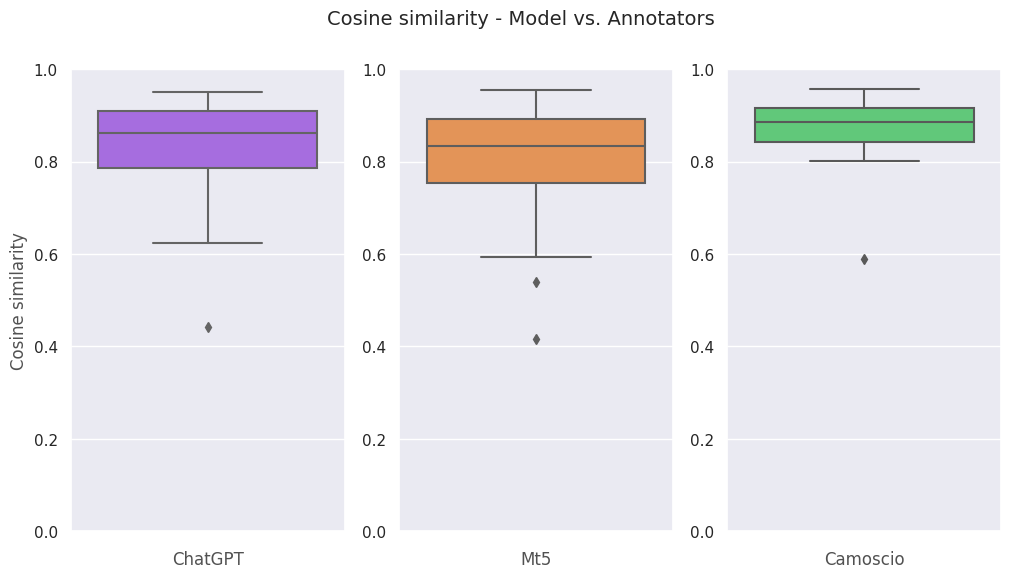

In [ ]:
f, (ax) = plt.subplots(1, 3, figsize=(12, 6))
f.suptitle('Cosine similarity - Model vs. Annotators', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = [mean(row) for row in blocco4_gpt], ax = ax[0], color = "#a65af2")
ax[0].set_xlabel("ChatGPT",size = 12,alpha=0.8)
ax[0].set_ylabel("Cosine similarity",size = 12,alpha=0.8)

sns.boxplot(data = [mean(row) for row in blocco4_mt5], ax=ax[1], color = "#fa9141")
ax[1].set_xlabel("Mt5",size = 12,alpha=0.8)

sns.boxplot(data = [mean(row) for row in blocco4_camoscio], ax=ax[2], color = "#50d971")
ax[2].set_xlabel("Camoscio",size = 12,alpha=0.8)

for a in ax:
  a.set(ylim=(0, 1))
  a.set_xticklabels([])

plt.show()

In [ ]:
blocco4_camoscio_na = []
blocco4_camoscio_max = []
blocco4_camoscio_min = []
last_camoscio_value_used = 0
for index in range(50):
  if camoscio_mask[index] :
    blocco4_camoscio_na.append( mean(blocco4_camoscio[last_camoscio_value_used]) )
    blocco4_camoscio_max.append( max(blocco4_camoscio[last_camoscio_value_used]) )
    blocco4_camoscio_min.append( min(blocco4_camoscio[last_camoscio_value_used]) )
    last_camoscio_value_used += 1
  else:
    blocco4_camoscio_na.append("n/a")
    blocco4_camoscio_max.append("n/a")
    blocco4_camoscio_min.append("n/a")

print(last_camoscio_value_used == len(blocco4_camoscio))

blocco4_cosine_table = {
    "ChatGPT mean" : [mean(row) for row in blocco4_gpt],
    "ChatGPT max" : [max(row) for row in blocco4_gpt],
    "ChatGPT min" : [min(row) for row in blocco4_gpt],
    "Mt5 mean" : [mean(row) for row in blocco4_mt5],
    "Mt5 max" : [max(row) for row in blocco4_mt5],
    "Mt5 min" : [min(row) for row in blocco4_mt5],
    "Camoscio mean" : blocco4_camoscio_na,
    "Camoscio max" : blocco4_camoscio_max,
    "Camoscio min" : blocco4_camoscio_min
}
blocco4_cosine_df = pd.DataFrame(blocco4_cosine_table)

blocco4_cosine_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/4cosine.xlsx")

blocco4_cosine_df

True


,ChatGPT mean,ChatGPT max,ChatGPT min,Mt5 mean,Mt5 max,Mt5 min,Camoscio mean,Camoscio max,Camoscio min
0,0.820182,0.914943,0.783173,0.894192,0.906276,0.882175,n/a,n/a,n/a
1,0.731860,0.778778,0.694265,0.636710,0.652557,0.615677,n/a,n/a,n/a
2,0.903640,0.910055,0.894483,0.823079,0.881050,0.799623,0.902497,0.902497,0.902497
3,0.849083,0.868157,0.836120,0.807211,0.881855,0.698766,0.854007,0.854007,0.854007
4,0.881054,0.899432,0.864099,0.858820,0.893303,0.831224,n/a,n/a,n/a
5,0.885073,0.923287,0.840829,0.783139,0.928567,0.684435,n/a,n/a,n/a
6,0.887721,0.948727,0.841402,0.861140,0.869303,0.849732,0.843194,0.843194,0.843194
7,0.923170,0.930589,0.918739,0.910883,0.915072,0.907008,n/a,n/a,n/a
8,0.920570,0.949331,0.881503,0.920014,0.935525,0.908494,n/a,n/a,n/a
9,0.818826,0.859738,0.783020,0.801225,0.870341,0.704213,n/a,n/a,n/a


# bleu

In [ ]:
def bleu_multics(humans, machine):
  # machine è lista a gruppi di 5, va calcolato score per ogni elemento
  references = [ par.split() for par in humans ]
  row_scores = []
  for par in machine:
    candidate = par.split()
    row_scores.append(sentence_bleu(references, candidate, smoothing_function = SmoothingFunction().method1))
  return row_scores

In [ ]:
blocco4_gpt_bleu = []
for index in range(50):
  blocco4_gpt_bleu.append(
      bleu_multics([jj[index], tomm[index], lucia[index]] , gpt_par[index])
  )

In [ ]:
blocco4_mt5_bleu = []
for index in range(50):
  blocco4_mt5_bleu.append(
      bleu_multics([jj[index], tomm[index], lucia[index]] , mt5_par[index])
  )

In [ ]:
blocco4_camoscio_bleu = []
for i in range(50):
  for j in range(len(camoscio_par)):
    if camoscio_par[j]["id"] == test_set_con_parafrasi[i]["id"]:
      blocco4_camoscio_bleu.append(
          bleu_multics([jj[i], tomm[i], lucia[i]] , camoscio_par[j]["par"])
      )

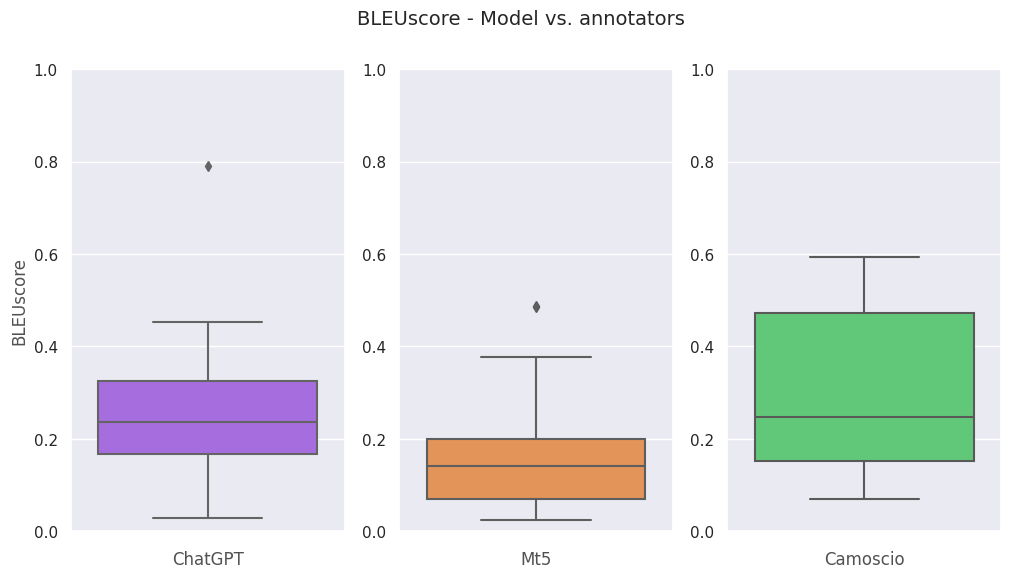

In [ ]:
f, (ax) = plt.subplots(1, 3, figsize=(12, 6))
f.suptitle('BLEUscore - Model vs. annotators', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = [mean(parafrasi) for parafrasi in blocco4_gpt_bleu], ax = ax[0], color = "#a65af2")
ax[0].set_xlabel("ChatGPT",size = 12,alpha=0.8)
ax[0].set_ylabel("BLEUscore",size = 12,alpha=0.8)

sns.boxplot(data = [mean(parafrasi) for parafrasi in blocco4_mt5_bleu], ax=ax[1], color = "#fa9141")
ax[1].set_xlabel("Mt5",size = 12,alpha=0.8)

sns.boxplot(data = [mean(parafrasi) for parafrasi in blocco4_camoscio_bleu], ax=ax[2], color = "#50d971")
ax[2].set_xlabel("Camoscio",size = 12,alpha=0.8)

for a in ax:
  a.set(ylim=(0, 1))
  a.set_xticklabels([])

plt.show()

Text(0, 0.5, 'BLEUscore')

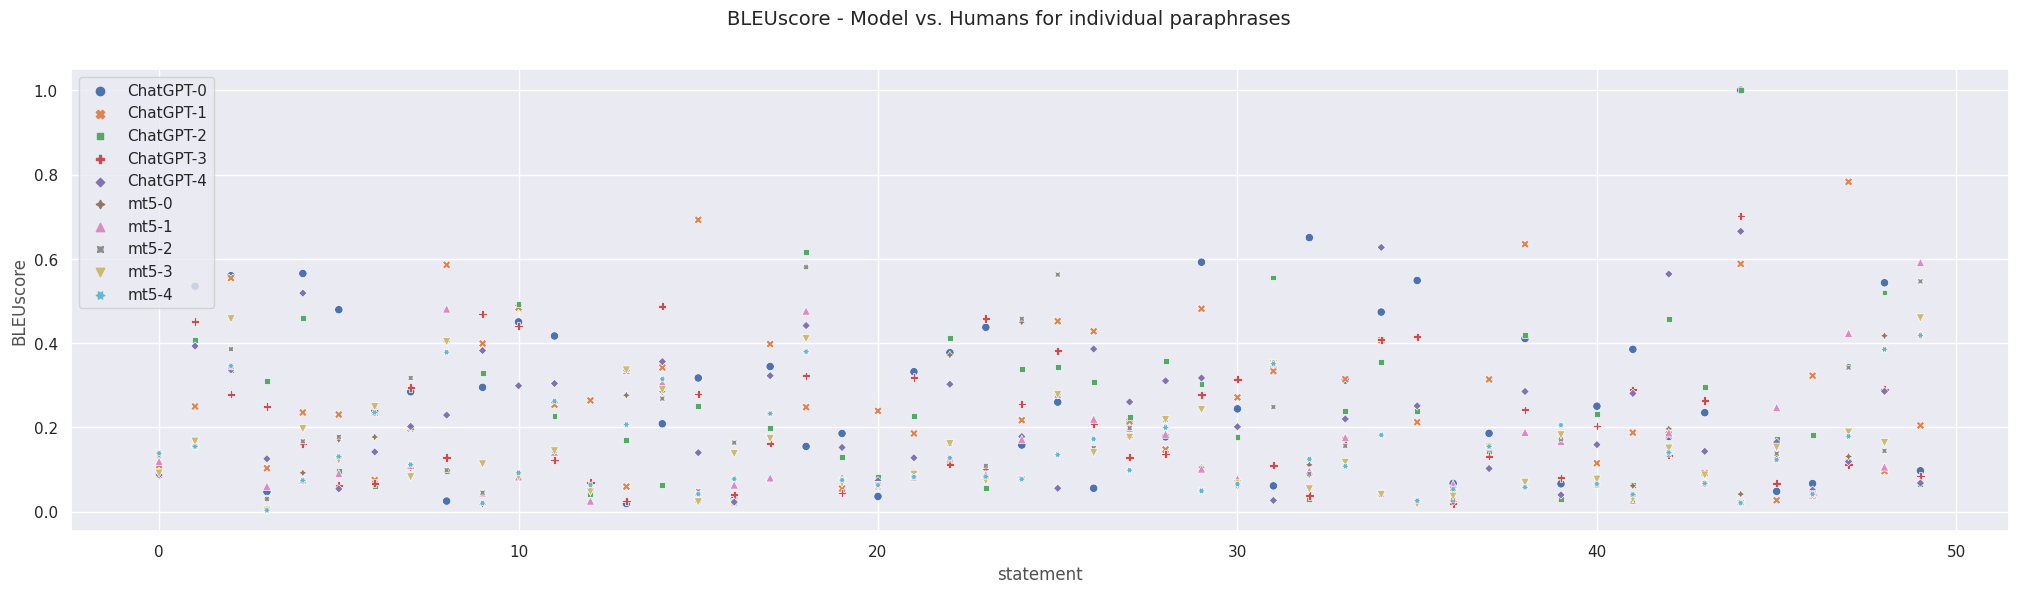

In [ ]:
blocco4_bleu_table = {
    "ChatGPT-0": [par[0] for par in blocco4_gpt_bleu],
    "ChatGPT-1": [par[1] for par in blocco4_gpt_bleu],
    "ChatGPT-2": [par[2] for par in blocco4_gpt_bleu],
    "ChatGPT-3": [par[3] for par in blocco4_gpt_bleu],
    "ChatGPT-4": [par[4] for par in blocco4_gpt_bleu],
    "mt5-0" : [par[0] for par in blocco4_mt5_bleu],
    "mt5-1" : [par[1] for par in blocco4_mt5_bleu],
    "mt5-2" : [par[2] for par in blocco4_mt5_bleu],
    "mt5-3" : [par[3] for par in blocco4_mt5_bleu],
    "mt5-4" : [par[4] for par in blocco4_mt5_bleu]
}

blocco4_bleu_df = pd.DataFrame(blocco4_bleu_table)

f, (ax) = plt.subplots(1, 1, figsize=(25, 6))
f.suptitle('BLEUscore - Model vs. Humans for individual paraphrases', fontsize=14)

sns.set(style="darkgrid")
sns.scatterplot(data = blocco4_bleu_df)
ax.set_xlabel("statement",size = 12,alpha=0.8)
ax.set_ylabel("BLEUscore",size = 12,alpha=0.8)

In [ ]:
blocco4_camoscio_bleu_na = []
blocco4_camoscio_bleu_max = []
blocco4_camoscio_bleu_min = []
last_camoscio_value_used = 0
for index in range(50):
  if camoscio_mask[index] :
    blocco4_camoscio_bleu_na.append(mean(blocco4_camoscio_bleu[last_camoscio_value_used]))
    blocco4_camoscio_bleu_max.append(max(blocco4_camoscio_bleu[last_camoscio_value_used]))
    blocco4_camoscio_bleu_min.append(min(blocco4_camoscio_bleu[last_camoscio_value_used]))
    last_camoscio_value_used += 1
  else:
    blocco4_camoscio_bleu_na.append("n/a")
    blocco4_camoscio_bleu_max.append("n/a")
    blocco4_camoscio_bleu_min.append("n/a")

print(last_camoscio_value_used == len(blocco4_camoscio))

blocco4_bleu_table = {
    "ChatGPT mean" : [mean(row) for row in blocco4_gpt_bleu],
    "ChatGPT max" : [max(row) for row in blocco4_gpt_bleu],
    "ChatGPT min" : [min(row) for row in blocco4_gpt_bleu],
    "Mt5 mean" : [mean(row) for row in blocco4_mt5_bleu],
    "Mt5 max" : [max(row) for row in blocco4_mt5_bleu],
    "Mt5 min" : [min(row) for row in blocco4_mt5_bleu],
    "Camoscio mean" : blocco4_camoscio_bleu_na,
    "Camoscio max" : blocco4_camoscio_bleu_max,
    "Camoscio min" : blocco4_camoscio_bleu_min
}
blocco4_bleu_df = pd.DataFrame(blocco4_bleu_table)

blocco4_bleu_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/4bleu.xlsx")

blocco4_bleu_df

True


,ChatGPT mean,ChatGPT max,ChatGPT min,Mt5 mean,Mt5 max,Mt5 min,Camoscio mean,Camoscio max,Camoscio min
0,0.091421,0.110021,0.086771,0.122211,0.138344,0.090926,n/a,n/a,n/a
1,0.407076,0.534665,0.249432,0.162470,0.166669,0.154340,n/a,n/a,n/a
2,0.413113,0.559788,0.278547,0.376230,0.457208,0.345791,0.592963,0.592963,0.592963
3,0.166792,0.309337,0.047436,0.025138,0.060016,0.003042,0.107335,0.107335,0.107335
4,0.387559,0.565086,0.160484,0.120762,0.196429,0.073930,n/a,n/a,n/a
5,0.184107,0.479071,0.053869,0.138091,0.177271,0.090312,n/a,n/a,n/a
6,0.116142,0.237368,0.059510,0.228907,0.248489,0.176950,0.227579,0.227579,0.227579
7,0.235516,0.294157,0.197406,0.144725,0.317023,0.082156,n/a,n/a,n/a
8,0.212860,0.585503,0.024808,0.352794,0.481098,0.098094,n/a,n/a,n/a
9,0.374759,0.468773,0.294743,0.047882,0.112856,0.017268,n/a,n/a,n/a


# BERT

In [ ]:
blocco4_gpt_bert = []
blocco4_mt5_bert = []
for i in range(50):
  blocco4_gpt_bert.append(bertscore.compute(predictions = gpt_par[i], references = [[jj[i], tomm[i], lucia[i]], [jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]]], lang="it"))
  blocco4_mt5_bert.append(bertscore.compute(predictions = mt5_par[i], references = [[jj[i], tomm[i], lucia[i]], [jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]]], lang="it"))

In [ ]:
blocco4_camoscio_bert = []
for j in range(50):
  for i in range(len(camoscio_par)):
    if camoscio_par[i]["id"] == test_set_con_parafrasi[j]["id"]:
      human_copies = []
      for numero_parafrasi in camoscio_par[i]["par"]:
        human_copies.append([jj[j], tomm[j], lucia[j]])
      blocco4_camoscio_bert.append(bertscore.compute(predictions = camoscio_par[i]["par"], references = human_copies, lang="it"))

In [ ]:
for i in range(50):
    del blocco4_gpt_bert[i]['hashcode']
    del blocco4_mt5_bert[i]['hashcode']
for i in range(len(blocco4_camoscio_bert)):
    del blocco4_camoscio_bert[i]['hashcode']

In [ ]:
blocco4_bert_table = []
for i in range(50):
  for key in blocco4_gpt_bert[i]:
    blocco4_bert_table.append({"scoreType" : key,
                  "scoreValue" : mean(blocco4_gpt_bert[i][key]),
                    "model" : "ChatGPT"
                    })
  for key in blocco4_mt5_bert[i]:
    blocco4_bert_table.append({"scoreType" : key,
                    "scoreValue" : mean(blocco4_mt5_bert[i][key]),
                    "model" : "mt5"
                    })
  if( i < len(blocco4_camoscio_bert)):
    for key in blocco4_camoscio_bert[i]:
      blocco4_bert_table.append({"scoreType" : key,
                      "scoreValue" : mean(blocco4_camoscio_bert[i][key]),
                      "model" : "camoscio"
                      })

Text(0, 0.5, 'BERTscore')

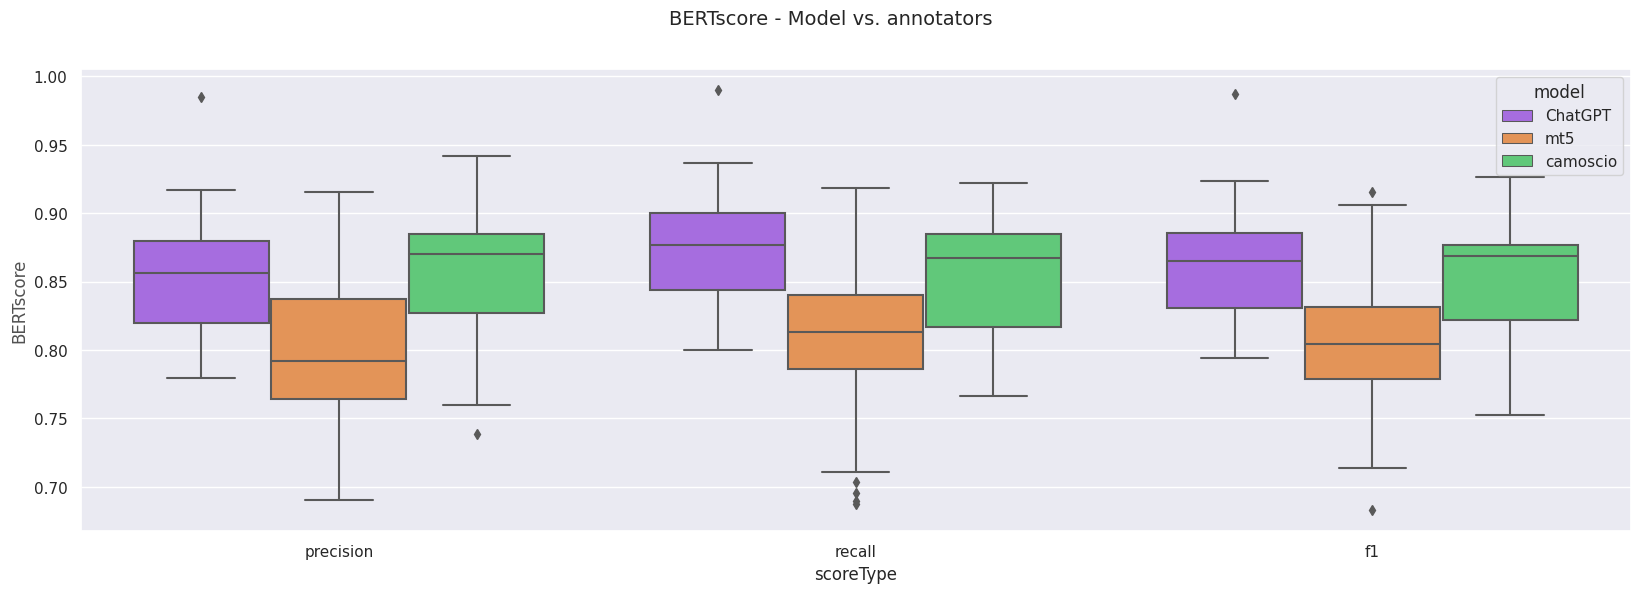

In [ ]:
blocco4_bert_df = pd.DataFrame(blocco4_bert_table)
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(20, 6))
f.suptitle('BERTscore - Model vs. annotators', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco4_bert_df, x = "scoreType", y = "scoreValue", hue="model", palette=["#a65af2", "#fa9141", "#50d971"])
ax.set_ylabel("BERTscore",size = 12,alpha=0.8)

In [ ]:
blocco4_camoscio_bert_na = []
blocco4_camoscio_bert_max = []
blocco4_camoscio_bert_min = []
last_camoscio_value_used = 0
for index in range(50):
  if(camoscio_mask[index]):
    blocco4_camoscio_bert_na.append({
        'precision' : mean(blocco4_camoscio_bert[last_camoscio_value_used]["precision"]),
        'recall' : mean(blocco4_camoscio_bert[last_camoscio_value_used]['recall']),
        'f1' : mean(blocco4_camoscio_bert[last_camoscio_value_used]['f1'])
    })
    blocco4_camoscio_bert_max.append({
        'precision' : max(blocco4_camoscio_bert[last_camoscio_value_used]["precision"]),
        'recall' : max(blocco4_camoscio_bert[last_camoscio_value_used]['recall']),
        'f1' : max(blocco4_camoscio_bert[last_camoscio_value_used]['f1'])
    })
    blocco4_camoscio_bert_min.append({
        'precision' : min(blocco4_camoscio_bert[last_camoscio_value_used]["precision"]),
        'recall' : min(blocco4_camoscio_bert[last_camoscio_value_used]['recall']),
        'f1' : min(blocco4_camoscio_bert[last_camoscio_value_used]['f1'])
    })
    last_camoscio_value_used += 1
  else:
    blocco4_camoscio_bert_na.append({'precision' : "n/a", "recall" : "n/a", "f1" : "n/a"})
    blocco4_camoscio_bert_max.append({'precision' : "n/a", "recall" : "n/a", "f1" : "n/a"})
    blocco4_camoscio_bert_min.append({'precision' : "n/a", "recall" : "n/a", "f1" : "n/a"})

last_camoscio_value_used == len(blocco4_camoscio_bert)

True

In [ ]:
blocco4_bert_better_table = {
    "ChatGPT precision mean" : [mean(row["precision"]) for row in blocco4_gpt_bert],
    "ChatGPT precision max" : [max(row["precision"]) for row in blocco4_gpt_bert],
    "ChatGPT precision min" : [min(row["precision"]) for row in blocco4_gpt_bert],
    "ChatGPT recall mean" : [mean(row["recall"]) for row in blocco4_gpt_bert],
    "ChatGPT recall max" : [max(row["recall"]) for row in blocco4_gpt_bert],
    "ChatGPT recall min" : [min(row["recall"]) for row in blocco4_gpt_bert],
    "ChatGPT f1 mean" : [mean(row["f1"]) for row in blocco4_gpt_bert],
    "ChatGPT f1 max" : [max(row["f1"]) for row in blocco4_gpt_bert],
    "ChatGPT f1 min" : [min(row["f1"]) for row in blocco4_gpt_bert],
    "Mt5 precision mean" : [mean(row["precision"]) for row in blocco4_mt5_bert],
    "Mt5 precision max" : [max(row["precision"]) for row in blocco4_mt5_bert],
    "Mt5 precision min" : [min(row["precision"]) for row in blocco4_mt5_bert],
    "Mt5 recall mean" : [mean(row["recall"]) for row in blocco4_mt5_bert],
    "Mt5 recall max" : [max(row["recall"]) for row in blocco4_mt5_bert],
    "Mt5 recall min" : [min(row["recall"]) for row in blocco4_mt5_bert],
    "Mt5 f1 mean" : [mean(row["f1"]) for row in blocco4_mt5_bert],
    "Mt5 f1 max" : [max(row["f1"]) for row in blocco4_mt5_bert],
    "Mt5 f1 min" : [min(row["f1"]) for row in blocco4_mt5_bert],
    "Camoscio precision mean" : [row["precision"] for row in blocco4_camoscio_bert_na],
    "Camoscio precision max" : [row["precision"] for row in blocco4_camoscio_bert_max],
    "Camoscio precision min" : [row["precision"] for row in blocco4_camoscio_bert_min],
    "Camoscio recall mean" : [row["recall"] for row in blocco4_camoscio_bert_na],
    "Camoscio recall max" : [row["recall"] for row in blocco4_camoscio_bert_max],
    "Camoscio recall min" : [row["recall"] for row in blocco4_camoscio_bert_min],
    "Camoscio f1 mean" : [row["f1"] for row in blocco4_camoscio_bert_na],
    "Camoscio f1 max" : [row["f1"] for row in blocco4_camoscio_bert_max],
    "Camoscio f1 min" : [row["f1"] for row in blocco4_camoscio_bert_min]
}
blocco4_bert_better_df = pd.DataFrame(blocco4_bert_better_table)

blocco4_bert_better_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/4bert.xlsx")

blocco4_bert_better_df

,ChatGPT precision mean,ChatGPT precision max,ChatGPT precision min,ChatGPT recall mean,ChatGPT recall max,ChatGPT recall min,ChatGPT f1 mean,ChatGPT f1 max,ChatGPT f1 min,Mt5 precision mean,...,Mt5 f1 min,Camoscio precision mean,Camoscio precision max,Camoscio precision min,Camoscio recall mean,Camoscio recall max,Camoscio recall min,Camoscio f1 mean,Camoscio f1 max,Camoscio f1 min
0,0.805645,0.815585,0.799037,0.799853,0.803532,0.790840,0.794224,0.803022,0.789845,0.787840,...,0.757423,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
1,0.877740,0.895129,0.846343,0.854978,0.868498,0.845573,0.865805,0.879806,0.845958,0.842150,...,0.802768,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
2,0.874987,0.905131,0.843625,0.857808,0.882252,0.841192,0.864828,0.892865,0.839727,0.867010,...,0.835267,0.885095,0.885095,0.885095,0.855762,0.855762,0.855762,0.861477,0.861477,0.861477
3,0.790676,0.799893,0.783153,0.814847,0.833721,0.784006,0.802512,0.816456,0.784204,0.690039,...,0.601652,0.738579,0.738579,0.738579,0.766294,0.766294,0.766294,0.752181,0.752181,0.752181
4,0.905148,0.934167,0.874493,0.900899,0.921175,0.881373,0.903002,0.927626,0.877919,0.825404,...,0.762043,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
5,0.827806,0.910208,0.788718,0.832032,0.887750,0.799328,0.829844,0.898839,0.798043,0.875509,...,0.790611,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
6,0.779253,0.792266,0.760745,0.826083,0.837264,0.813321,0.801781,0.814143,0.789861,0.915358,...,0.899939,0.883505,0.883505,0.883505,0.869694,0.869694,0.869694,0.876116,0.876116,0.876116
7,0.841725,0.860145,0.830914,0.805176,0.810665,0.796562,0.814856,0.834024,0.804131,0.813844,...,0.750475,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
8,0.818929,0.856465,0.759278,0.816592,0.869096,0.762905,0.810656,0.849578,0.761087,0.897237,...,0.844448,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
9,0.875321,0.902343,0.846583,0.890580,0.927176,0.864157,0.882846,0.914591,0.855280,0.759532,...,0.707833,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a


# ROUGE

In [ ]:
blocco4_gpt_rouge = []
blocco4_mt5_rouge = []
for i in range(50):
  blocco4_gpt_rouge.append(rouge.compute(predictions = gpt_par[i], references = [[jj[i], tomm[i], lucia[i]], [jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]]],use_aggregator=False))
  blocco4_mt5_rouge.append(rouge.compute(predictions = mt5_par[i], references = [[jj[i], tomm[i], lucia[i]], [jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]],[jj[i], tomm[i], lucia[i]]],use_aggregator=False))

In [ ]:
blocco4_camoscio_rouge = []
for j in range(50):
  for i in range(len(camoscio_par)):
    if camoscio_par[i]["id"] == test_set_con_parafrasi[j]["id"]:
      human_copies = []
      for numero_parafrasi in camoscio_par[i]["par"]:
        human_copies.append([jj[j], tomm[j], lucia[j]])
      blocco4_camoscio_rouge.append(rouge.compute(predictions = camoscio_par[i]["par"], references = human_copies,use_aggregator=False))

In [ ]:
blocco4_rouge_table = []
for i in range(50):
  for key in blocco4_gpt_rouge[i]:
    blocco4_rouge_table.append({"scoreType" : key,
                  "scoreValue" : mean(blocco4_gpt_rouge[i][key]),
                    "model" : "ChatGPT"
                    })
  for key in blocco4_mt5_rouge[i]:
    blocco4_rouge_table.append({"scoreType" : key,
                    "scoreValue" : mean(blocco4_mt5_rouge[i][key]),
                    "model" : "mt5"
                    })
  if( i < len(blocco4_camoscio_rouge)):
    for key in blocco4_camoscio_rouge[i]:
      blocco4_rouge_table.append({"scoreType" : key,
                      "scoreValue" : mean(blocco4_camoscio_rouge[i][key]),
                      "model" : "camoscio"
                      })

Text(0, 0.5, 'ROUGEscore')

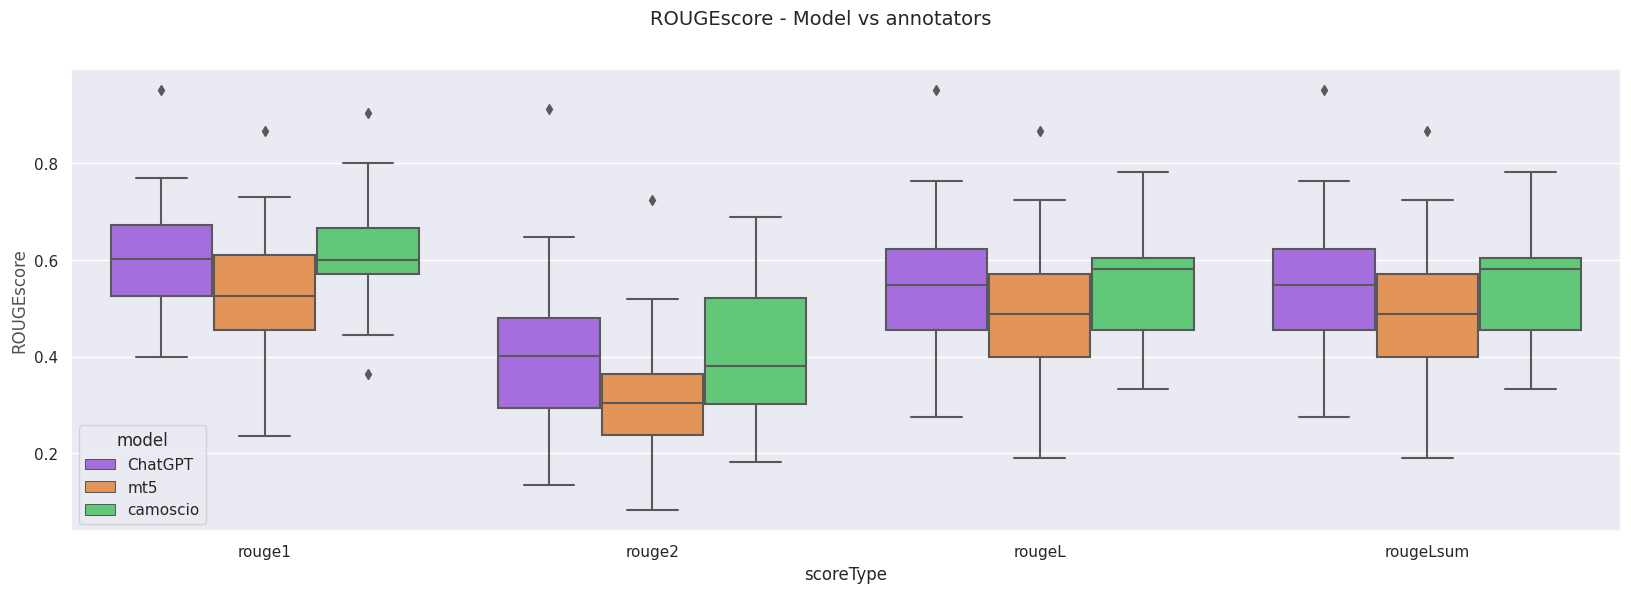

In [ ]:
blocco4_rouge_df = pd.DataFrame(blocco4_rouge_table)
# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(20, 6))
f.suptitle('ROUGEscore - Model vs annotators', fontsize=14)

sns.set(style="darkgrid")
sns.boxplot(data = blocco4_rouge_df, x = "scoreType", y = "scoreValue", hue="model", palette=["#a65af2", "#fa9141", "#50d971"])
ax.set_ylabel("ROUGEscore",size = 12,alpha=0.8)

In [ ]:
blocco4_camoscio_rouge_na = []
blocco4_camoscio_rouge_max = []
blocco4_camoscio_rouge_min = []
last_camoscio_value_used = 0
for index in range(50):
  if(camoscio_mask[index]):
    blocco4_camoscio_rouge_na.append({
        'rouge1' : mean(blocco4_camoscio_rouge[last_camoscio_value_used]["rouge1"]),
        'rouge2' : mean(blocco4_camoscio_rouge[last_camoscio_value_used]['rouge2']),
        'rougeL' : mean(blocco4_camoscio_rouge[last_camoscio_value_used]['rougeL']),
        'rougeLsum' : mean(blocco4_camoscio_rouge[last_camoscio_value_used]['rougeLsum'])
    })
    blocco4_camoscio_rouge_max.append({
        'rouge1' : max(blocco4_camoscio_rouge[last_camoscio_value_used]["rouge1"]),
        'rouge2' : max(blocco4_camoscio_rouge[last_camoscio_value_used]['rouge2']),
        'rougeL' : max(blocco4_camoscio_rouge[last_camoscio_value_used]['rougeL']),
        'rougeLsum' : max(blocco4_camoscio_rouge[last_camoscio_value_used]['rougeLsum'])
    })
    blocco4_camoscio_rouge_min.append({
        'rouge1' : min(blocco4_camoscio_rouge[last_camoscio_value_used]["rouge1"]),
        'rouge2' : min(blocco4_camoscio_rouge[last_camoscio_value_used]['rouge2']),
        'rougeL' : min(blocco4_camoscio_rouge[last_camoscio_value_used]['rougeL']),
        'rougeLsum' : min(blocco4_camoscio_rouge[last_camoscio_value_used]['rougeLsum'])
    })
    last_camoscio_value_used += 1
  else:
    blocco4_camoscio_rouge_na.append({'rouge1' : "n/a", "rouge2" : "n/a", "rougeL" : "n/a", "rougeLsum" : "n/a"})
    blocco4_camoscio_rouge_max.append({'rouge1' : "n/a", "rouge2" : "n/a", "rougeL" : "n/a", "rougeLsum" : "n/a"})
    blocco4_camoscio_rouge_min.append({'rouge1' : "n/a", "rouge2" : "n/a", "rougeL" : "n/a", "rougeLsum" : "n/a"})

last_camoscio_value_used == len(blocco4_camoscio_rouge)

True

In [ ]:
blocco4_rouge_better_table = {
    "ChatGPT rouge1 mean" : [mean(row["rouge1"]) for row in blocco4_gpt_rouge],
    "ChatGPT rouge1 max" : [max(row["rouge1"]) for row in blocco4_gpt_rouge],
    "ChatGPT rouge1 min" : [min(row["rouge1"]) for row in blocco4_gpt_rouge],
    "ChatGPT rouge2 mean" : [mean(row["rouge2"]) for row in blocco4_gpt_rouge],
    "ChatGPT rouge2 max" : [max(row["rouge2"]) for row in blocco4_gpt_rouge],
    "ChatGPT rouge2 min" : [min(row["rouge2"]) for row in blocco4_gpt_rouge],
    "ChatGPT rougeL mean" : [mean(row["rougeL"]) for row in blocco4_gpt_rouge],
    "ChatGPT rougeL max" : [max(row["rougeL"]) for row in blocco4_gpt_rouge],
    "ChatGPT rougeL min" : [min(row["rougeL"]) for row in blocco4_gpt_rouge],
    "ChatGPT rougeLsum mean" : [mean(row["rougeLsum"]) for row in blocco4_gpt_rouge],
    "ChatGPT rougeLsum max" : [max(row["rougeLsum"]) for row in blocco4_gpt_rouge],
    "ChatGPT rougeLsum min" : [min(row["rougeLsum"]) for row in blocco4_gpt_rouge],

    "Mt5 rouge1 mean" : [mean(row["rouge1"]) for row in blocco4_mt5_rouge],
    "Mt5 rouge1 max" : [max(row["rouge1"]) for row in blocco4_mt5_rouge],
    "Mt5 rouge1 min" : [min(row["rouge1"]) for row in blocco4_mt5_rouge],
    "Mt5 rouge2 mean" : [mean(row["rouge2"]) for row in blocco4_mt5_rouge],
    "Mt5 rouge2 max" : [max(row["rouge2"]) for row in blocco4_mt5_rouge],
    "Mt5 rouge2 min" : [min(row["rouge2"]) for row in blocco4_mt5_rouge],
    "Mt5 rougeL mean" : [mean(row["rougeL"]) for row in blocco4_mt5_rouge],
    "Mt5 rougeL max" : [max(row["rougeL"]) for row in blocco4_mt5_rouge],
    "Mt5 rougeL min" : [min(row["rougeL"]) for row in blocco4_mt5_rouge],
    "Mt5 rougeLsum mean" : [mean(row["rougeLsum"]) for row in blocco4_mt5_rouge],
    "Mt5 rougeLsum max" : [max(row["rougeLsum"]) for row in blocco4_mt5_rouge],
    "Mt5 rougeLsum min" : [min(row["rougeLsum"]) for row in blocco4_mt5_rouge],

    "Camoscio rouge1 mean" : [row["rouge1"] for row in blocco4_camoscio_rouge_na],
    "Camoscio rouge1 max" : [row["rouge1"] for row in blocco4_camoscio_rouge_max],
    "Camoscio rouge1 min" : [row["rouge1"] for row in blocco4_camoscio_rouge_min],
    "Camoscio rouge2 mean" : [row["rouge2"] for row in blocco4_camoscio_rouge_na],
    "Camoscio rouge2 max" : [row["rouge2"] for row in blocco4_camoscio_rouge_max],
    "Camoscio rouge2 min" : [row["rouge2"] for row in blocco4_camoscio_rouge_min],
    "Camoscio rougeL mean" : [row["rougeL"] for row in blocco4_camoscio_rouge_na],
    "Camoscio rougeL max" : [row["rougeL"] for row in blocco4_camoscio_rouge_max],
    "Camoscio rougeL min" : [row["rougeL"] for row in blocco4_camoscio_rouge_min],
    "Camoscio rougeLsum mean" : [row["rougeLsum"] for row in blocco4_camoscio_rouge_na],
    "Camoscio rougeLsum max" : [row["rougeLsum"] for row in blocco4_camoscio_rouge_max],
    "Camoscio rougeLsum min" : [row["rougeLsum"] for row in blocco4_camoscio_rouge_min]
}
blocco4_rouge_better_df = pd.DataFrame(blocco4_rouge_better_table)

blocco4_rouge_better_df.to_excel("/content/gdrive/MyDrive/Jacopo/paper/tabelle/4rouge.xlsx")

blocco4_rouge_better_df

,ChatGPT rouge1 mean,ChatGPT rouge1 max,ChatGPT rouge1 min,ChatGPT rouge2 mean,ChatGPT rouge2 max,ChatGPT rouge2 min,ChatGPT rougeL mean,ChatGPT rougeL max,ChatGPT rougeL min,ChatGPT rougeLsum mean,...,Camoscio rouge1 min,Camoscio rouge2 mean,Camoscio rouge2 max,Camoscio rouge2 min,Camoscio rougeL mean,Camoscio rougeL max,Camoscio rougeL min,Camoscio rougeLsum mean,Camoscio rougeLsum max,Camoscio rougeLsum min
0,0.426667,0.533333,0.400000,0.194505,0.357143,0.153846,0.295238,0.333333,0.285714,0.295238,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
1,0.700207,0.763158,0.648649,0.479484,0.540541,0.370370,0.638534,0.710526,0.554217,0.638534,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
2,0.763948,0.875000,0.666667,0.648140,0.800000,0.529412,0.763948,0.875000,0.666667,0.763948,...,0.903226,0.689655,0.689655,0.689655,0.774194,0.774194,0.774194,0.774194,0.774194,0.774194
3,0.525817,0.577320,0.488372,0.326074,0.391304,0.261905,0.425583,0.489362,0.320000,0.425583,...,0.444444,0.226415,0.226415,0.226415,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
4,0.702929,0.821429,0.548387,0.537966,0.703704,0.285714,0.696477,0.821429,0.516129,0.696477,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
5,0.584377,0.842105,0.470588,0.349564,0.666667,0.227273,0.567170,0.842105,0.468085,0.567170,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
6,0.470694,0.576923,0.382979,0.247295,0.440000,0.170213,0.377244,0.461538,0.326531,0.377244,...,0.604651,0.390244,0.390244,0.390244,0.604651,0.604651,0.604651,0.604651,0.604651,0.604651
7,0.495745,0.571429,0.437500,0.299723,0.357143,0.250000,0.474878,0.533333,0.411765,0.474878,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
8,0.614000,0.888889,0.320000,0.396300,0.720000,0.086957,0.505407,0.740741,0.240000,0.505407,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
9,0.676649,0.750000,0.642857,0.454662,0.548387,0.354839,0.619103,0.750000,0.468750,0.619103,...,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
